
    down trans_up       up 
     602      389      785 

[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99"

Warning message:
“Since you have set `order`, you should better set `grid.col` as a named
vector where sector names are the vector names, or else the color will
be wrongly assigned.”
Warning message:
“Since you have set `group`, you should better set `grid.col` as a named
vector where sector names are the vector names, or else the color will
be wrongly assigned.”
Note: 1 point is out of plotting region in sector 'EN_down', track '1'.

Note: 1 point is out of plotting region in sector 'EN_down', track '1'.

Note: 7 points are out of plotting region in sector 'EN_down', track
'1'.

Note: 1 point is out of plotting region in sector 'EN_trans_down',
track '1'.

Note: 1 point is out of plotting region in sector 'EN_trans_down',
track '1'.

Note: 13 points are out of plotting region in sector 'EN_trans_down',
track '1'.

Note: 1 point is out of plotting region in sector 'EN_up', track '1'.

Note: 1 point is out of plotting region in sector 'EN_up', track '1'.

Note: 5 points are out of plott

pdf 
  2

null device 
          1

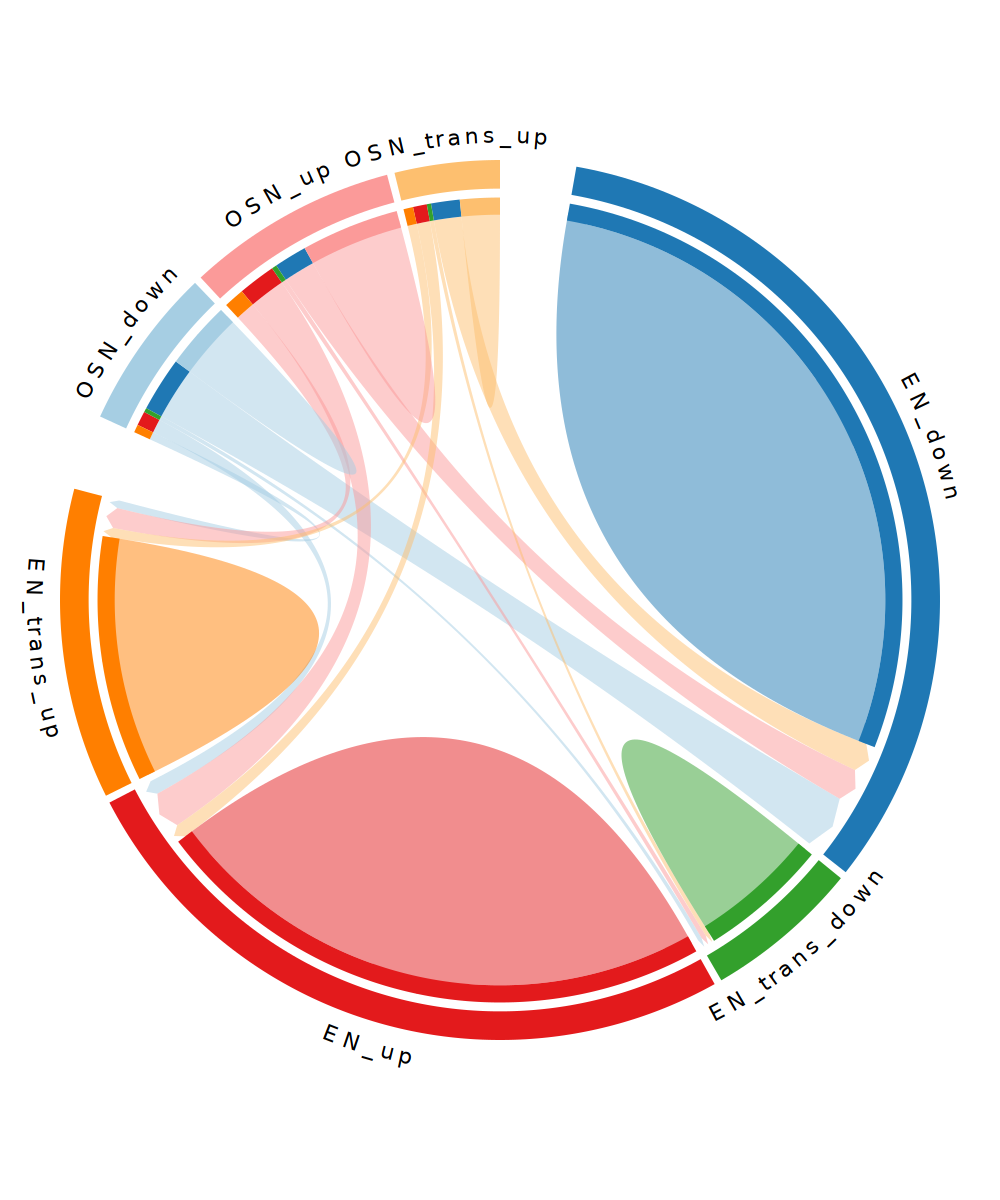

In [3]:
library(stringr)
library(gprofiler2)
library(rrvgo)
library(ggplot2)

options(repr.plot.width = 10, repr.plot.height = 12, repr.plot.res = 100)


dev_files <- list.files('/sc/arion/projects/roussp01a/liting/Olf/data/lister_devDEG/', '.txt')
dev_gs <- c()
for(fl in dev_files){
  dev_g <- read.table(paste0('/sc/arion/projects/roussp01a/liting/Olf/data/lister_devDEG/',fl),header = T)
  cell_type <- gsub('\\.txt|-','',fl)
  dev_g$celltype <- cell_type
  dev_gs <- rbind(dev_g,dev_gs)
}

dev_gs <- subset(dev_gs, !grepl('^MT|^LINC|^MIR|^RP',gene_name ) & celltype=="L23_CUX2")

#num_devG_trend <- lapply( split(dev_gs,dev_gs$trend_class), function(x) table(x$gene_name))

# consensus DEGs across cell types in each trend
down_brain <- subset(dev_gs, trend_class=='down')[,"gene_name"]
up_brain <- subset(dev_gs, trend_class=='up')[,"gene_name"]
trans_down_brain <- subset(dev_gs, trend_class=='trans_down')[,"gene_name"]
trans_up_brain <- subset(dev_gs, trend_class=='trans_up')[,"gene_name"]

DEG_trend_Brain <- list(down=down_brain, 
                        up=up_brain, 
                        trans_down=trans_down_brain, 
                        trans_up=trans_up_brain)


# OLF devDEGs
#load('/sc/arion/projects/roussp01a/liting/Olf/data/DEG_trend_Olf_k6.RData')
load('/sc/arion/projects/roussp01a/liting/Olf/data/DEG_trend_Olf_k7_graph.RData')
table(DEG_trend_Olf$trend_class)

# format DEG_overlap_gene[trend_Olf][trend_Brain]
DEG_overlap_gene <- list()
for (t1 in c('down','up','trans_down','trans_up')){
  DEG_overlap_gene[[t1]] <- lapply(DEG_trend_Brain, function(x) intersect( x, DEG_trend_Olf$gene[DEG_trend_Olf$trend_class==t1]) )
}


n_DEG_overlap_gene <- as.data.frame(unlist(lapply(DEG_overlap_gene, function(x) lapply(x, length) )))
n_DEG_overlap_gene <- cbind(n_DEG_overlap_gene, str_split( rownames(n_DEG_overlap_gene),'\\.',simplify = T))
colnames(n_DEG_overlap_gene) <- c('n','Olf_trend','Brain_trend')
n_DEG_overlap_gene$Olf_trend <- paste0('OSN_',n_DEG_overlap_gene$Olf_trend)
n_DEG_overlap_gene$Brain_trend <- paste0('EN_',n_DEG_overlap_gene$Brain_trend)

unique_olf <- table((subset(DEG_trend_Olf,!gene%in% unlist(DEG_trend_Brain)))$trend_class)
unique_brain <- sapply(DEG_trend_Brain, function(x) length(setdiff(x, DEG_trend_Olf$gene)))

uniq_genes <- as.data.frame(rbind(
  cbind(
    unique_olf,
    paste0('OSN_', names(unique_olf) ),
    paste0('OSN_',  names(unique_olf) )
  ),
  cbind(
    unique_brain,
    paste0('EN_', names(unique_brain) ) ,
    paste0('EN_', names(unique_brain) ) 
  )))
colnames(uniq_genes) <- c('n','Olf_trend','Brain_trend')

n_cicle_DE <- rbind(n_DEG_overlap_gene, uniq_genes)

n_cicle_DE$n <- as.numeric(n_cicle_DE$n)

# ggplot(n_DEG_overlap_gene, aes(x=Olf_trend,y=Brain_trend))+
#   geom_tile(aes(fill = n))
library(circlize)

library(RColorBrewer)
brewer.pal(n = 5, name = "Paired")


col_fun = colorRamp2(seq(1,300,50), rev(brewer.pal(6, "RdBu")))
#col <- ifelse(n_cicle_DE$Olf_trend!=n_cicle_DE$Brain_trend,col_fun(n_cicle_DE$n), "#FFFFFF00")

library(RColorBrewer)
circos.par(start.degree = 80)
nm = c(paste0(c("OSN_"), c('down','trans_down','up','trans_up')), paste0(c("EN_"), c('down','trans_down','up','trans_up')))
group = structure(c(rep('OSN_',4),rep('EN_',4)), names = nm)

chordDiagram(n_cicle_DE[,c(2,3,1)], self.link = 1, 
             order = nm,
             grid.col = brewer.pal(n = 8, name = "Paired")[c(1,3,5,7,2,4,6,8)],
             #col=col, 
             annotationTrack = c("grid"),
             annotationTrackHeight = mm_h(5) ,
             diffHeight = mm_h(3), target.prop.height = mm_h(5),
             directional = 1, direction.type = c("diffHeight", "arrows"), 
             link.arr.type = "big.arrow",
             group = group,
             big.gap = 10)

for(si in get.all.sector.index()) {
  xlim = get.cell.meta.data("xlim", sector.index = si, track.index = 1)
  ylim = get.cell.meta.data("ylim", sector.index = si, track.index = 1)
  circos.text(mean(xlim), 2, si, sector.index = si, track.index = 1, cex = 1.3,
              facing = "bending.inside", niceFacing = TRUE, col = "black")
}
circos.clear()
#draw(x = unit(0.82, "npc"), y = unit(0.6, "npc"),just="left",Legend(col_fun = col_fun, title = "Number of links"))
dev.print(pdf, file='./figures/devdeg_overlap.pdf',width=6.6, height=7)
dev.off()



In [2]:
n_DEG_overlap_gene
221/602
39/389
152/785

#602      389      785 
#DEG_trend_Olf['TCF4',]

,n,Olf_trend,Brain_trend
,<int>,<chr>,<chr>
down.down,221,OSN_down,EN_down
down.up,58,OSN_down,EN_up
down.trans_down,17,OSN_down,EN_trans_down
down.trans_up,32,OSN_down,EN_trans_up
up.down,133,OSN_up,EN_down
up.up,152,OSN_up,EN_up
up.trans_down,20,OSN_up,EN_trans_down
up.trans_up,83,OSN_up,EN_trans_up
trans_down.down,0,OSN_trans_down,EN_down


[1] 0.3671096

[1] 0.1002571

[1] 0.1936306

In [2]:
load('./data/custom_olfbg.RData')
load('./data/lister_brain_bg.RData')
overlap_bg <- intersect(brain_bg,custom_olfbg )


Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”
Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“number of items read is not a multiple of the number of columns”


pdf 
  2

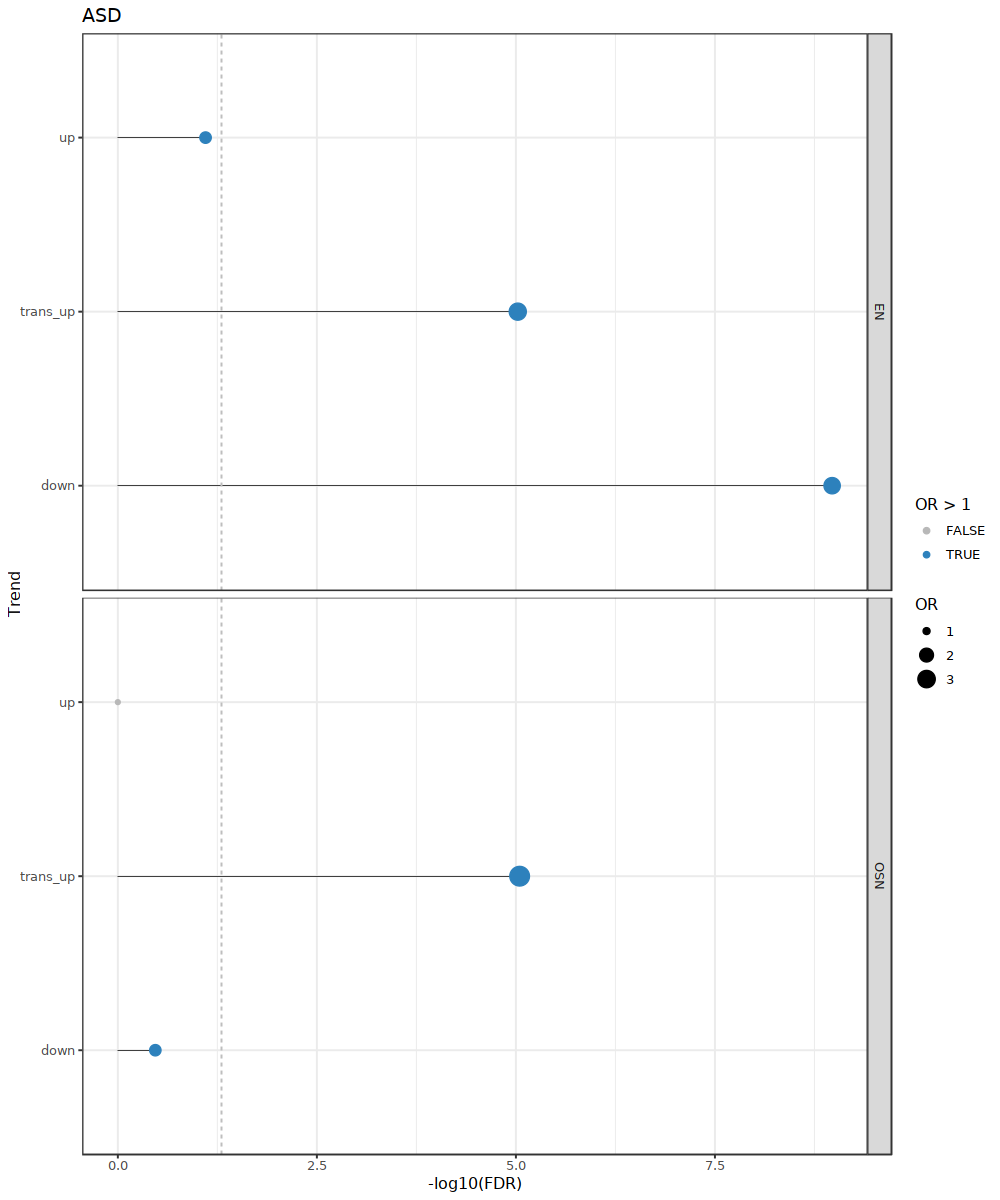

In [83]:
SFARI <- read.table('./data/SFARI.txt', sep='\t',header = T)
SFARI <- subset(SFARI, gene.score==1|syndromic==1)
ASD <- SFARI$gene.symbol

fisher <- function(Disease, DEG, BG){
    Disease <- intersect(Disease, BG)
    aa <- length(intersect(Disease, DEG))
    bb <- length(setdiff(Disease, DEG))
    cc <- length(setdiff(DEG, Disease))
    dd <- length(setdiff(BG, c(Disease, DEG)))
    
    test <- fisher.test(matrix(c(aa,bb,cc,dd),2),alternative='greater')

    return(paste(test$p.value, test$estimate, sep='~'))
}

enrich_D_EN <- c()

for (trend in names(DEG_trend_Brain)){
        pv <- fisher(Disease=ASD,
               DEG = DEG_trend_Brain[[trend]], 
               BG= brain_bg)
    enrich_D_EN <- rbind(enrich_D_EN, c(trend, pv, paste(intersect(DEG_trend_Brain[[trend]],ASD),collapse=',') ) )
   
 }
enrich_D_EN <- as.data.frame(enrich_D_EN)
colnames(enrich_D_EN) <- c('trend','p_or','gene')

enrich_D_EN$p <- as.numeric(str_split(enrich_D_EN$p_or,'~',simplify = T)[,1])
enrich_D_EN$OR <- as.numeric(str_split(enrich_D_EN$p_or,'~',simplify = T)[,2])
enrich_D_EN$FDR <- p.adjust(enrich_D_EN$p)

enrich_D_EN$Cell <- 'EN'

enrich_D_osn <- c()

for (trend in unique(DEG_trend_Olf$trend_class)){
        pv <- fisher(Disease=ASD,
               DEG = subset(DEG_trend_Olf,trend_class==trend)[,'gene'], 
               BG= custom_olfbg)
    enrich_D_osn <- rbind(enrich_D_osn, c(trend, pv, paste(intersect(subset(DEG_trend_Olf,trend_class==trend)[,'gene'],
                  ASD),collapse=',') ) )
   
 }
enrich_D_osn <- as.data.frame(enrich_D_osn)
colnames(enrich_D_osn) <- c('trend','p_or','gene')

enrich_D_osn$p <- as.numeric(str_split(enrich_D_osn$p_or,'~',simplify = T)[,1])
enrich_D_osn$OR <- as.numeric(str_split(enrich_D_osn$p_or,'~',simplify = T)[,2])
enrich_D_osn$FDR <- p.adjust(enrich_D_osn$p)

enrich_D_osn$Cell <- 'OSN'

enrich_D <- rbind(enrich_D_EN, enrich_D_osn)
enrich_D$FDR <- p.adjust(enrich_D$p)

ggplot(subset(enrich_D,trend!='trans_down' ), aes (x=trend, y=-log10(FDR),size=OR,color=OR>1))+
facet_grid(Cell~.,scales = 'free_y')+
geom_segment(aes(x = trend, xend = trend, y = 0, yend = -log10(FDR)), 
              color = "black", size = 0.2)+theme_bw()+
geom_point()+
labs(y='-log10(FDR)',x='Trend',color='OR > 1',title='ASD')+coord_flip()+
geom_hline(yintercept=-log10(0.05),  linetype='dashed', col = 'gray')+
scale_color_manual(values =  c('#B8B8B8','#2D81BC'))

dev.print(pdf, file='./figures/SFARI.pdf', width=4, height=3.5)


### enriched pathway of different gene sets

In [5]:
# overlappped gene pathway enrichment

get_bp <- function(olf_trend, brain_trend){
  enrr <- c()
  query_gene <- DEG_overlap_gene[[olf_trend]][[brain_trend]]
  
  if (length(query_gene)>20){
    enriched <- gost(query_gene,source=c('GO:BP'),correction_method = "fdr",custom_bg = overlap_bg,user_threshold=0.1,significant=F)
    enrr <- enriched$result %>%subset(term_size < 2000)
    
    enrr$olf_trend <- olf_trend
    enrr$brain_trend <- brain_trend
    
  }
  return(enrr) 
}

gobps_devDEG <- c()
for (olf_trend in c('up','down','trans_up','trans_down')){
  for(brain_trend in c('up','down','trans_up','trans_down')){
    gobp_devDEG <- get_bp(olf_trend, brain_trend)
    gobps_devDEG <- rbind(gobps_devDEG, gobp_devDEG)
  }
}

# brain unique gene
unique_brain <- sapply(DEG_trend_Brain, function(x) setdiff(x, DEG_trend_Olf$gene))

unique_brain_gobp <- lapply(unique_brain, function(x) {df <-    gost(x, source=c('GO:BP'),custom_bg = brain_bg,  
                                                                     correction_method = "fdr",user_threshold=0.1,
                                                                    #evcodes=T,
                                                                     significant=F)$result %>%subset(term_size < 2000)  } )
                       
unique_brain_gobps <- do.call(rbind,unique_brain_gobp)
unique_brain_gobps$brain_trend <- str_split(rownames(unique_brain_gobps),pattern = '\\.',simplify = T)[,1]

# olf unique gene
unique_olf <- subset(DEG_trend_Olf,!gene%in% unlist(DEG_trend_Brain))
unique_olf <- split(unique_olf$gene,unique_olf$trend_class)
unique_olf_gobp <- lapply(unique_olf, function(x) {df <-    gost(x, source=c('GO:BP'), custom_bg = custom_olfbg, 
                                                                 #evcodes=T,
                                                                 correction_method = "fdr",user_threshold=0.1,significant=F)$result %>%subset(term_size < 2000)  } )

unique_olf_gobps <- do.call(rbind,unique_olf_gobp)
unique_olf_gobps$olf_trend <- str_split(rownames(unique_olf_gobps),pattern = '\\.',simplify = T)[,1]


Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope i

In [13]:
# input for magma
brain_unique_gene <- as.data.frame(unlist(unique_brain))
brain_unique_gene$cat <- paste0('EN',gsub('\\d+','',rownames(brain_unique_gene)))
colnames(brain_unique_gene) <- c('gene','cat')

olf_unique_gene <- as.data.frame(unlist(unique_olf))
olf_unique_gene$cat <- paste0('OSN',gsub('\\d+','',rownames(olf_unique_gene)))
colnames(olf_unique_gene) <- c('gene','cat')

overlap_gene <- as.data.frame(unlist(DEG_overlap_gene))
overlap_gene$cat <- paste0(gsub('\\d+','',rownames(overlap_gene)))
colnames(overlap_gene) <- c('gene','cat')

deggenes <- rbind(brain_unique_gene, olf_unique_gene, overlap_gene)
#save(deggenes, file='./data/deggenes1.RData')
#deggenes <- subset(deggenes, cat%in%names(table(deggenes$cat))[which(table(deggenes$cat)> 30)])
deggenes$catmerge <- ifelse(grepl('\\.',deggenes$cat ),str_split(deggenes$cat,pattern = '\\.',simplify = T)[,1], deggenes$cat)

save(deggenes, file='./data/deggenes.RData')
#split(deggenes$gene,deggenes$cat)
    

In [14]:
table(deggenes$catmerge)


        down       ENdown ENtrans_down   ENtrans_up         ENup      OSNdown 
         311         2844          523          997         2307          274 
 OSNtrans_up        OSNup     trans_up           up 
         161          397          211          368 

In [268]:
# xxx <- gprofiler2::gost(unique_brain$down,
#      evcodes=T)
# xxx1 <- gost(str_split(subset(xxx$result,term_name=='neurogenesis')$intersection,','),sources='GO:BP')$result%>%subset(term_size< 2000)
# xxx1[1:10,]

# xx <- gprofiler2::gost(unique_olf$down,
#      evcodes=T)
# xx1 <- gost(str_split(subset(xx$result,term_name=='neurogenesis')$intersection,','),sources='GO:BP')$result%>%subset(term_size< 2000)
# xx1[1:10,]

In [269]:
table(deggenes$cat)


        down.down     down.trans_up           down.up            ENdown 
              221                32                58              2844 
     ENtrans_down        ENtrans_up              ENup           OSNdown 
              523               997              2307               274 
      OSNtrans_up             OSNup     trans_up.down trans_up.trans_up 
              161               397               116                39 
      trans_up.up           up.down       up.trans_up             up.up 
               56               133                83               152 

### plot enriched gobp

In [279]:
unique_brain_gobps$trend <- paste0("EN-specific " , unique_brain_gobps$brain_trend)
unique_olf_gobps$trend <- paste0("OSN-specific " , unique_olf_gobps$olf_trend)
gobps_devDEG$trend <- ifelse(gobps_devDEG$olf_trend==gobps_devDEG$brain_trend,
                             paste0('Shared ', gobps_devDEG$olf_trend),
                             paste0("OSN-",gobps_devDEG$olf_trend,' ~ ','EN-', gobps_devDEG$brain_trend))

p1 <- unique_brain_gobps[,c('p_value','intersection_size','term_name','term_id','trend')]
p2 <- unique_olf_gobps[,c('p_value','intersection_size','term_name','term_id','trend')]
p3 <- gobps_devDEG[,c('p_value','intersection_size','term_name','term_id','trend')]

pp <- rbind(p1,p2,p3)


library(dplyr)
# pp_sig <- subset(pp, p_value < 0.05)
# #pp_sig$p_value  <- pp_sig$p_value+c(1:nrow(pp_sig))/10000000
# pp_sig <- pp_sig%>%group_by(trend)%>%top_n(5, -p_value)


pp$p_value  <- pp$p_value+c(1:nrow(pp_sig))/(0.1/min(pp$p_value))

Warning message in pp$p_value + c(1:nrow(pp_sig))/(0.1/min(pp$p_value)):
“longer object length is not a multiple of shorter object length”


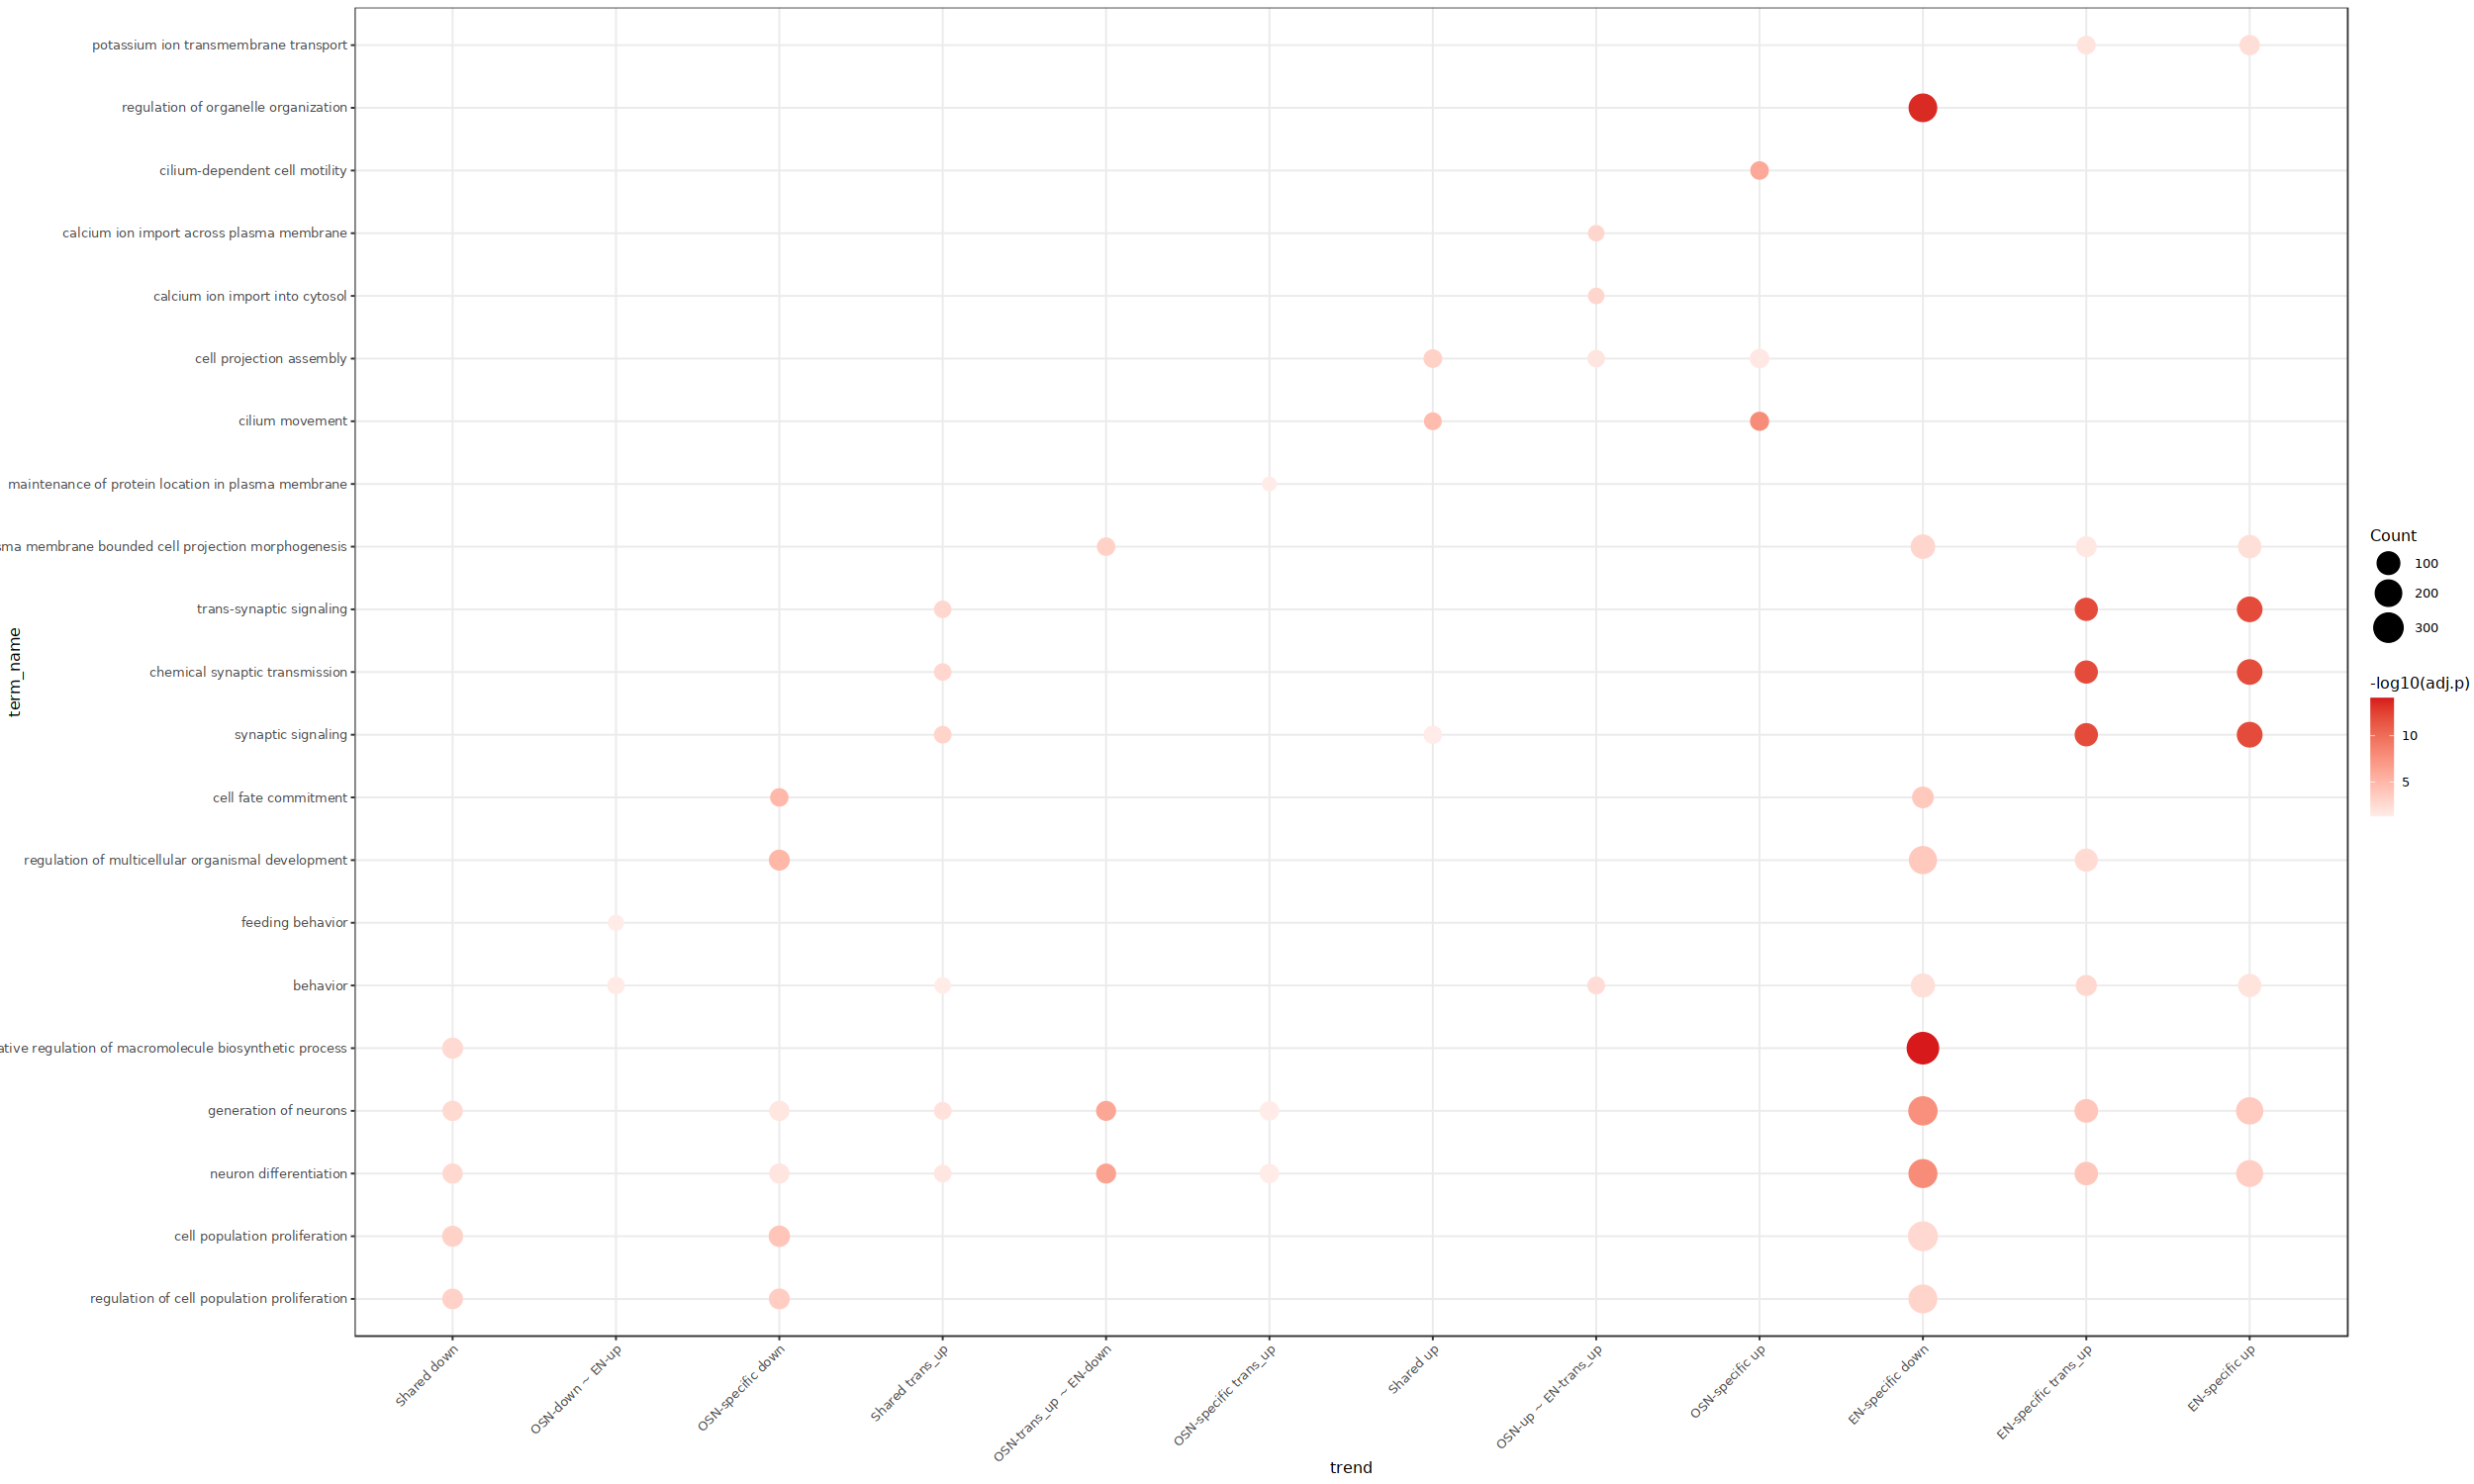

In [279]:
pp_sig <- pp%>%group_by(trend)%>%top_n(2, -p_value)
pp_sig <- subset(pp, term_name%in%pp_sig$term_name)%>%subset(p_value < 0.05)

# order_pattern <- c(
#     'Shared down','OSN-down ~ EN-trans_down','OSN-down ~ EN-up','OSN-down ~ EN-trans_up','OSN-specific down','EN-specific down',
#     'Shared trans_up','OSN-trans_up ~ EN-down','OSN-trans_up ~ EN-trans_down','OSN-trans_up ~ EN-up','OSN-specific trans_up','EN-specific trans_up',
#     'Shared trans_down','OSN-trans_down ~ EN-up','OSN-trans_down ~ EN-trans_up','OSN-specific trans_down','EN-specific trans_down',
#     'Shared up', 'OSN-up ~ EN-trans_up','OSN-up ~ EN-down', 'OSN-up ~ EN-trans_down', 'OSN-specific up','EN-specific up'
#  )

order_pattern <- c(
    'Shared down','OSN-down ~ EN-trans_down','OSN-down ~ EN-up','OSN-down ~ EN-trans_up','OSN-specific down',
    'Shared trans_up','OSN-trans_up ~ EN-down','OSN-trans_up ~ EN-trans_down','OSN-trans_up ~ EN-up','OSN-specific trans_up',
    'Shared trans_down','OSN-trans_down ~ EN-up','OSN-trans_down ~ EN-trans_up','OSN-specific trans_down',
    'Shared up', 'OSN-up ~ EN-trans_up','OSN-up ~ EN-down', 'OSN-up ~ EN-trans_down', 'OSN-specific up',
    'EN-specific down','EN-specific trans_up','EN-specific trans_down','EN-specific up'
 )

pp_sig <- subset(pp_sig, trend!='EN-specific trans_down')

pp_sig$trend <- factor(pp_sig$trend,levels = order_pattern)


pp_sig <- pp_sig[order(pp_sig$trend),]


pp_sig$term_name <- factor(pp_sig$term_name, levels=unique(pp_sig$term_name))


ggplot(pp_sig, aes(x=trend,y=term_name,size=intersection_size,color=-log10(p_value)))+geom_point() +
            scale_size(range = c(4, 10)) +
            labs( size = "Count", color = "-log10(adj.p)") +
            scale_color_gradient2(high="#D7191C", mid="white", low="#2C7BB6", name = "-log10(adj.p)")+theme_bw()+
theme(axis.text.x=element_text(angle=45, hjust=1,vjust=1))

In [280]:
get_bp_enrichr_reducedTerms <- function(go_analysis){
  #go_analysis$GOID <- str_split(go_analysis$Term,'\\(|\\)',simplify = T)[,2]
  simMatrix <- calculateSimMatrix(go_analysis$term_id,
                                  orgdb="org.Hs.eg.db",
                                  ont=c('BP'),
                                  method="Rel")
  
  
  scores <- setNames(-log10(as.numeric(go_analysis$p_value)), go_analysis$term_id)
  reducedTerms <- reduceSimMatrix(simMatrix,
                                  scores,
                                  orgdb="org.Hs.eg.db")

  return(reducedTerms)
  
}
pp_sig <- subset(pp_sig, trend!='EN-specific trans_down')
pp_sigx <- pp_sig
pp_sigx <- pp_sigx[order(-pp_sigx$p_value),]
pp_sigx <- pp_sigx[ !duplicated(pp_sigx$term_id),]
pp_sigx_reducedTerms <- get_bp_enrichr_reducedTerms(pp_sigx)
rownames(pp_sigx_reducedTerms) <- pp_sigx_reducedTerms$term

preparing gene to GO mapping data...

preparing IC data...

'select()' returned 1:many mapping between keys and columns



In [272]:
#pp_sigx_reducedTerms[,c("term","parentTerm")]
#dcast(subset(pp_sig,trend!='EN-specific trans_down')[,c("term_name","trend","p_value")],trend~term_name)
#pp_sig <- subset(pp_sig, trend!='EN-specific trans_down')


In [281]:
library(reshape2)
dpp <- dcast(subset(pp_sig,trend!='EN-specific trans_down')[,c("term_name","trend","p_value")],trend~term_name)
rownames(dpp) <- dpp$trend
dpp <- dpp[,-1]
dpp <- -log10(dpp)


# oe_trend <-  c('down','trans_down','up','trans_up','')
# en_trend <- c('down','trans_down','up','trans_up','')

oe_trend <-  c('down','trans_down','up','trans_up','')
en_trend <- c('down','trans_down','up','trans_up','')

oe_color <- brewer.pal(n = 8, name = "Paired")[c(1,3,5,7)]
names(oe_color) <- oe_trend[1:4]

en_color <- brewer.pal(n = 8, name = "Paired")[c(2,4,6,8)]
names(en_color) <- en_trend[1:4]


trend <- expand.grid(en_trend,oe_trend)
colnames(trend) <- c('EN', 'OSN')
#trend$oe_color <- oe_color[trend$OSN]
#trend$en_color <- en_color[trend$EN]

trend <- within(trend,{
    pattern <- ''
    pattern[OSN==''] <- paste0("EN-specific ", EN[OSN==''])
    pattern[EN==''] <- paste0("OSN-specific ", OSN[EN==''])
    pattern[OSN==EN] <- paste0('Shared ',OSN[OSN==EN])
    pattern[is.na(pattern)] <- paste0("OSN-",OSN[is.na(pattern)],' ~ ','EN-', EN[is.na(pattern)])
  
}
)
rownames(trend) <- trend$pattern
#trend

Using p_value as value column: use value.var to override.



In [274]:
#dpp[intersect(order_pattern,rownames(dpp)),]#unique(pp_sig$term_name)]
#unique(pp_sig$term_name)

In [282]:
options(repr.plot.width = 25, repr.plot.height = 15, repr.plot.res = 100)
go_color=brewer.pal(n = 12, name = "Set3")[1:length(unique(pp_sigx_reducedTerms$parentTerm))]
names(go_color) <- unique(pp_sigx_reducedTerms$parentTerm)

library(ComplexHeatmap)

dpp <- dpp[intersect(order_pattern,rownames(dpp)),unique(pp_sig$term_name)]
dpp_fullname <- colnames(dpp)
colnames(dpp) <- gsub('regulation','reg.',colnames(dpp))

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


pdf 
  2

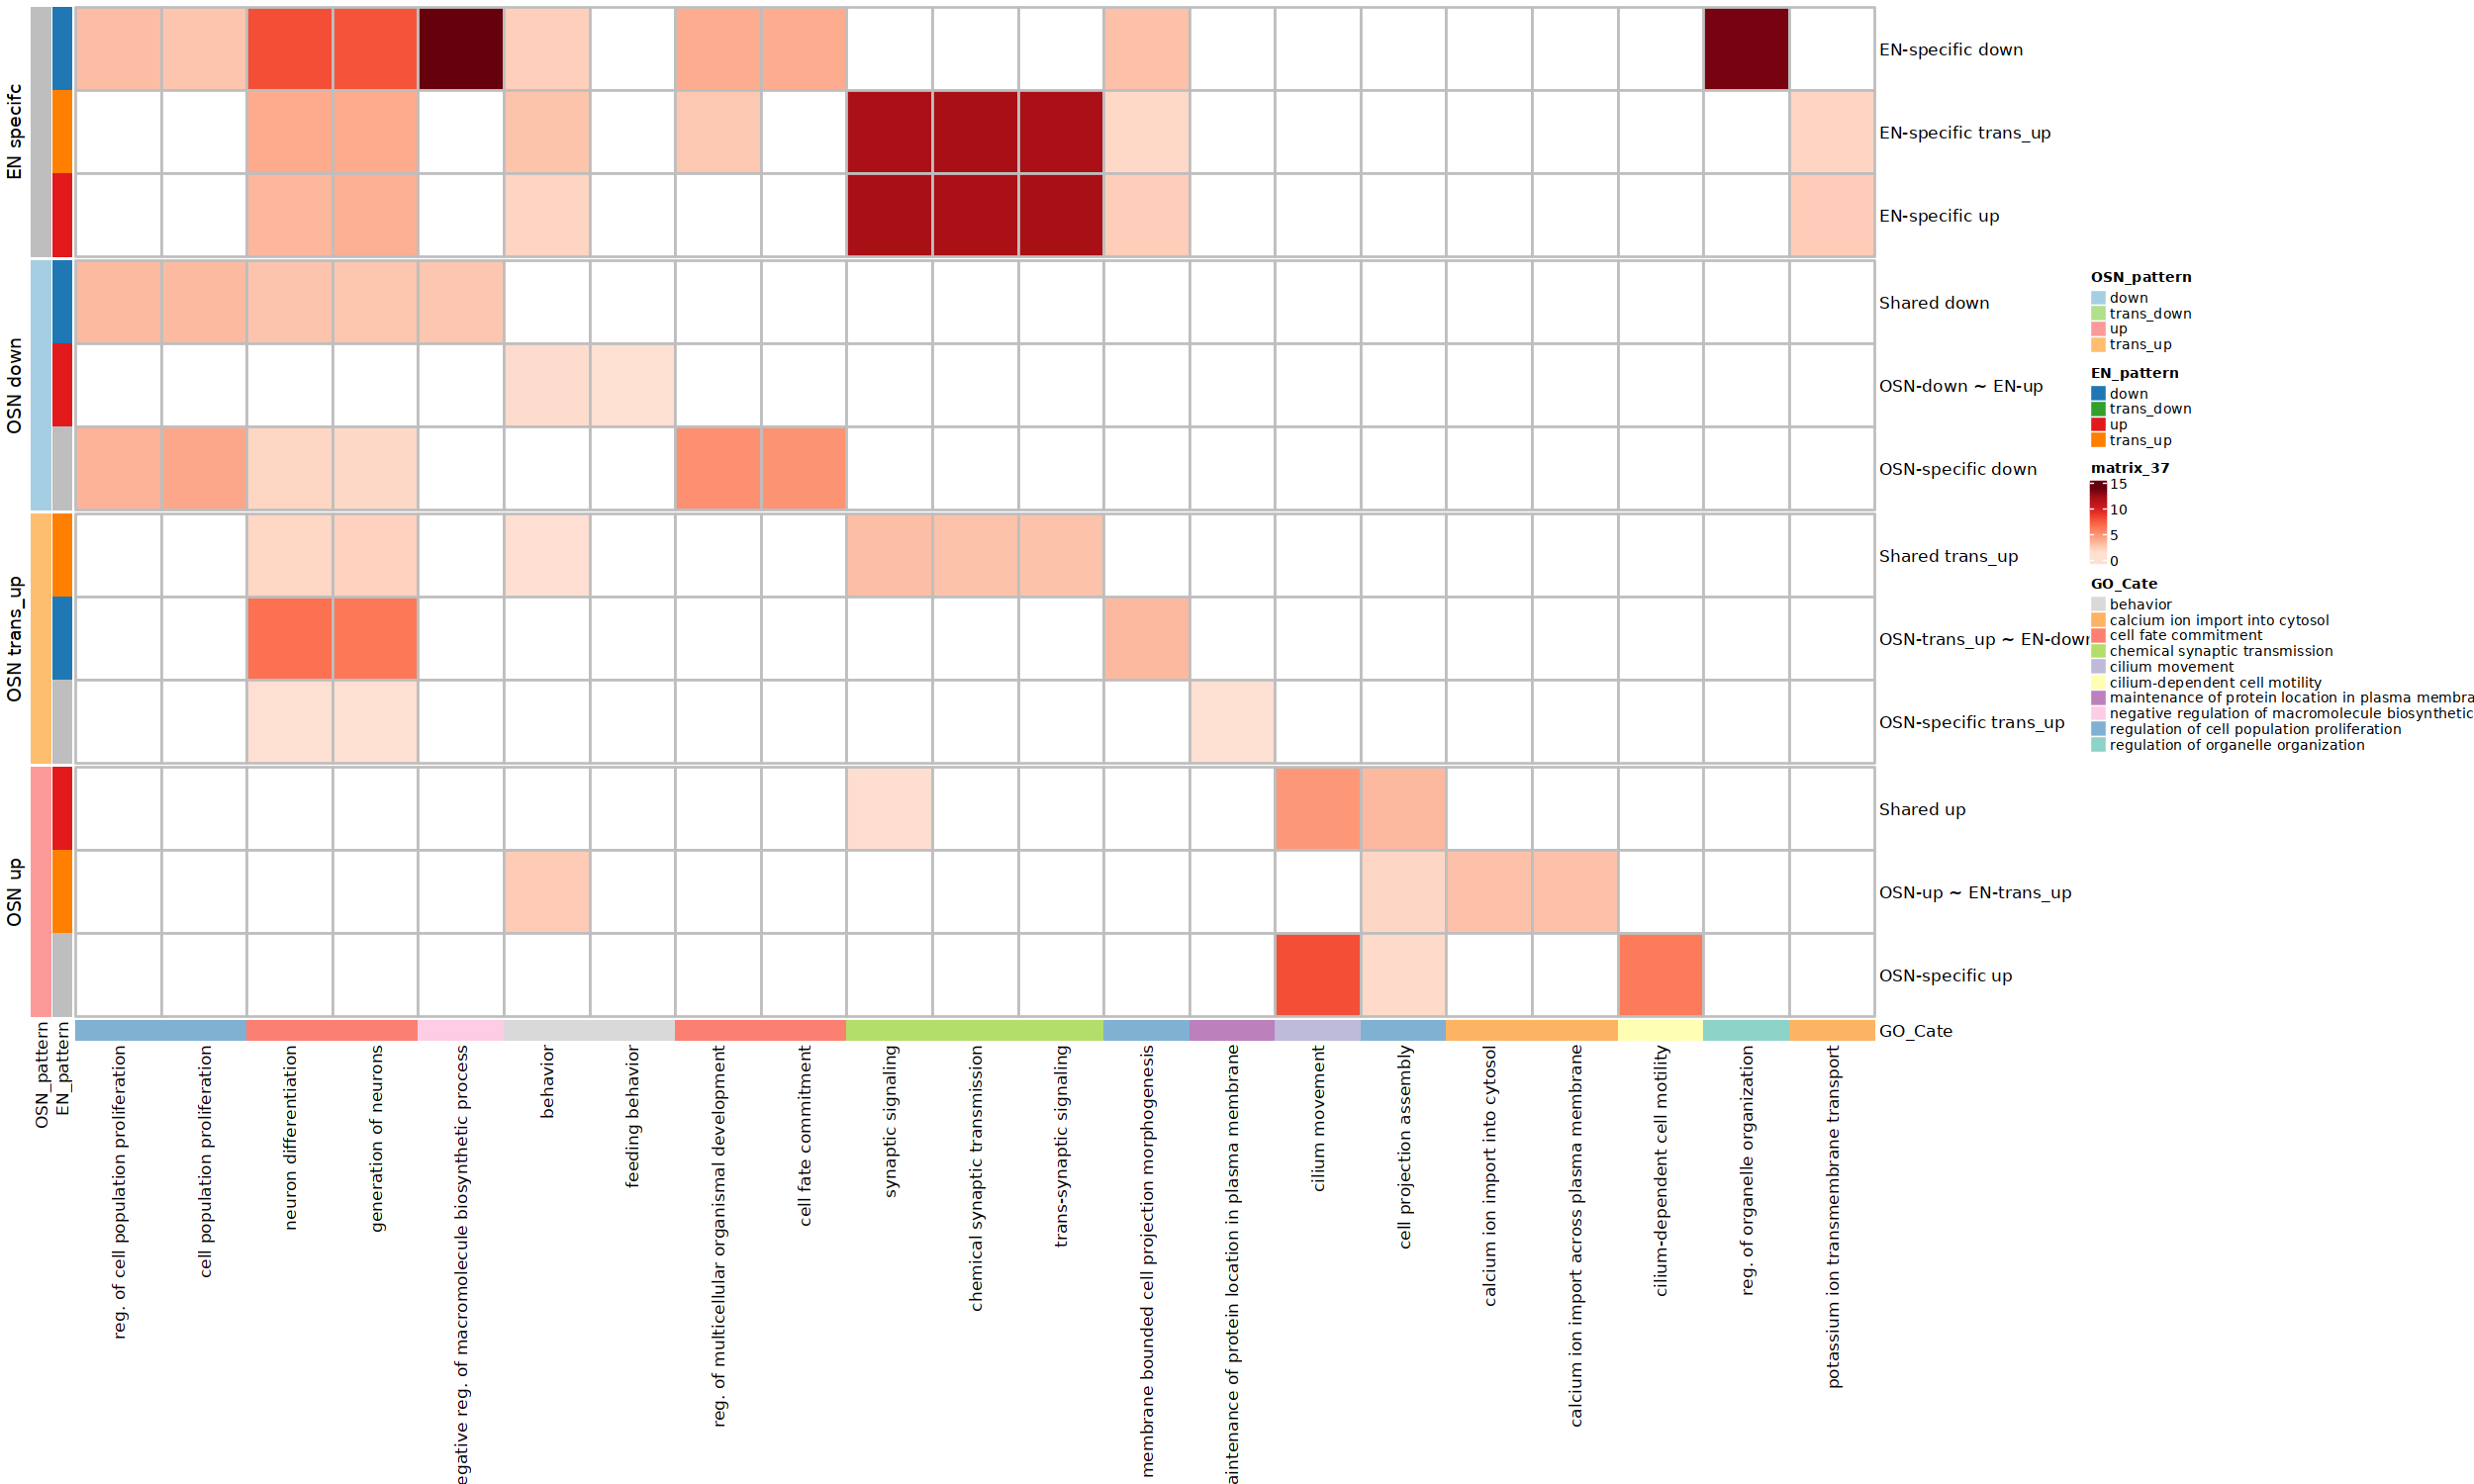

In [286]:
#dpp
ht_list <- Heatmap(
  dpp,
    na_col = "white",
    col                          = colorRamp2(seq(from=min(dpp,na.rm = T),to=max(dpp,na.rm = T),length=8),brewer.pal(9, "Reds")[-1]),
    cluster_columns              = F,
    cluster_rows                 = F,
    show_row_names               = T,
    show_column_names            = T,
    row_names_max_width = unit(15, "cm"),
    column_names_max_height  = unit(15, "cm"),
    show_row_dend = F,
    bottom_annotation = HeatmapAnnotation(
               GO_Cate=pp_sigx_reducedTerms[dpp_fullname,'parentTerm'],
    col=list(GO_Cate=go_color)
    ),
    rect_gp = gpar(col = "grey", lwd = 2),
    left_annotation=rowAnnotation(
        # pattern=rownames(dpp),
        OSN_pattern = trend[rownames(dpp),'OSN'],
        EN_pattern = trend[rownames(dpp),'EN'],
        col = list(OSN_pattern = oe_color,
                  EN_pattern=en_color)
    ),
    #row_split = trend[rownames(dpp),'OSN']
    row_split = c(rep('OSN down',3), rep('OSN trans_up',3),rep('OSN up',3),rep('EN specifc',3))
)


draw(ht_list, merge_legend = TRUE, heatmap_legend_side = "right", 
     annotation_legend_side = "right")

dev.print(pdf, file='./figures/go_circle2.pdf', height=9, width=14)

# PART2: direct pathway overlap-------------------GOBP level----------------------------------------------------------------------------------------------

#### pathway olf

In [91]:
#library(enrichR)
library(dplyr)

DEG_Olf_bytrend <- split(DEG_trend_Olf$gene,DEG_trend_Olf$trend_class)
DEG_trend_Olf_gobp <- lapply(DEG_Olf_bytrend, function(x) {df <-    gost(x, source='GO:BP', 
                                                                        custom_bg = custom_olfbg,
                                                                         correction_method = "fdr",
                                                                         #evcodes = TRUE,
                                                                         user_threshold=0.1,significant=F)$result %>%subset(term_size < 2000)  }) 

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.



In [92]:
#subset(DEG_trend_Olf_gobp$trans_up, grepl('dend',term_name))

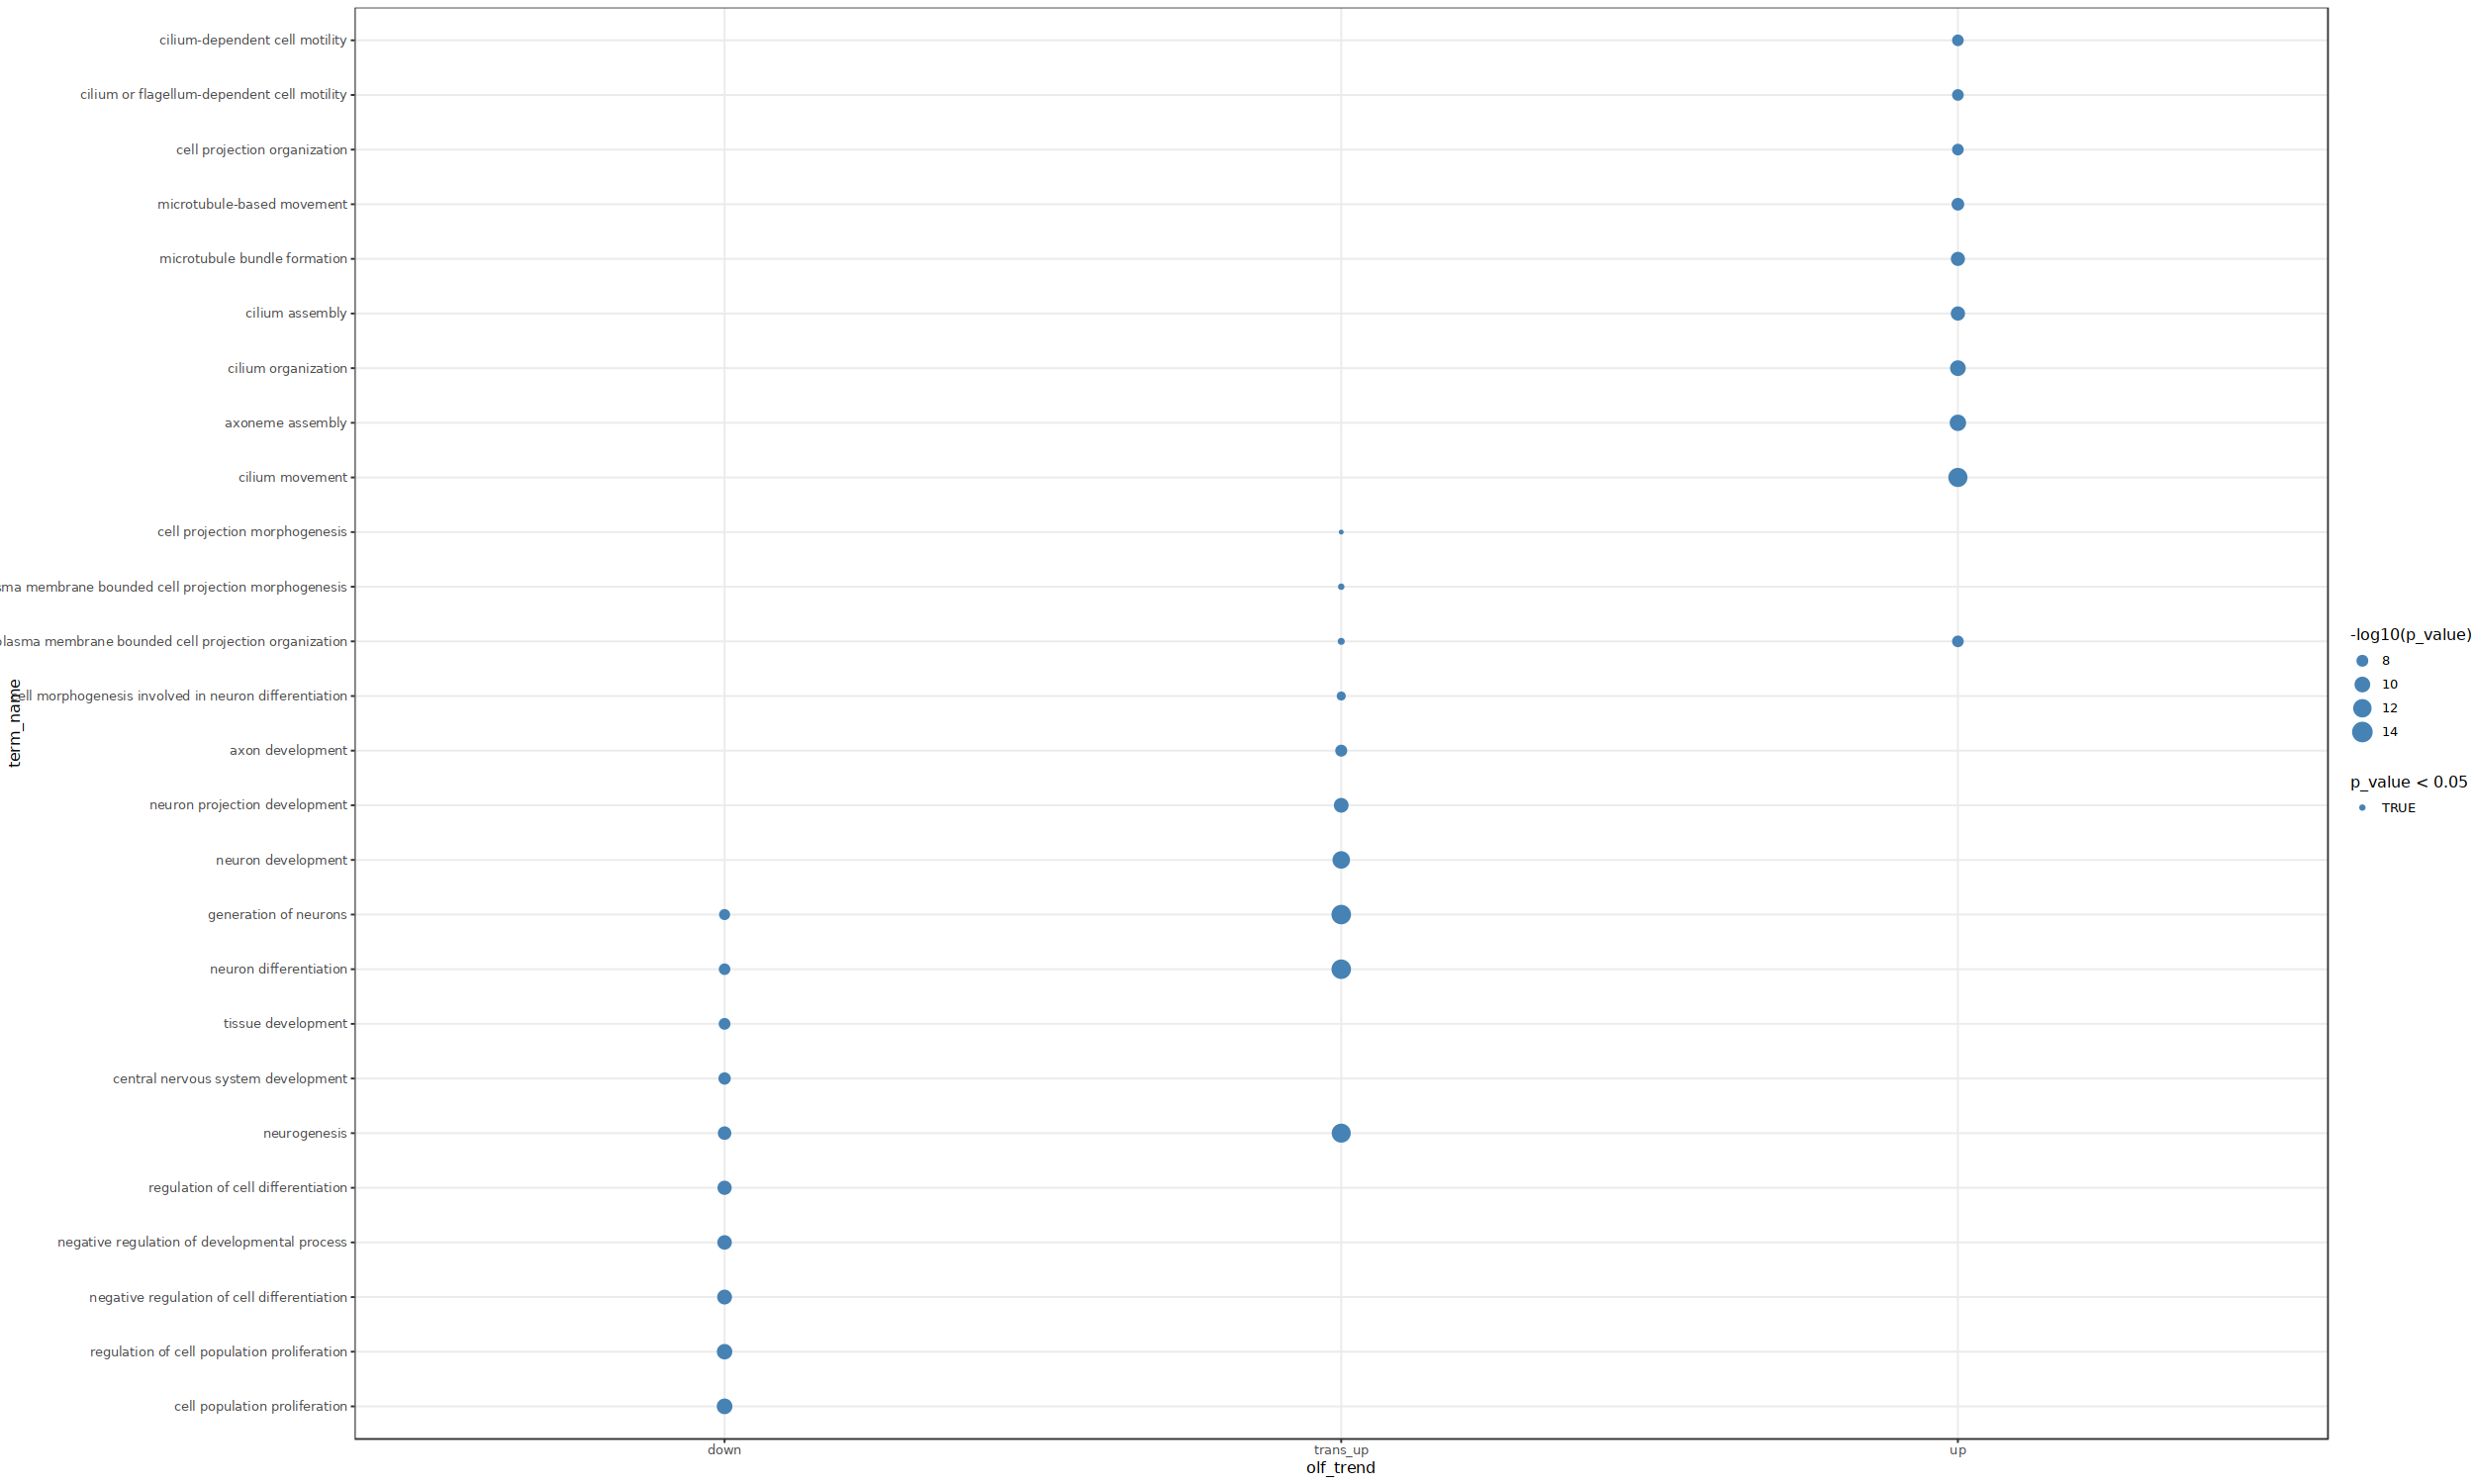

In [93]:
                       
DEG_trend_Olf_gobps <- do.call(rbind,DEG_trend_Olf_gobp)
DEG_trend_Olf_gobps$olf_trend <- str_split(rownames(DEG_trend_Olf_gobps),pattern = '\\.',simplify = T)[,1]
gobps_olf_sig <- subset(DEG_trend_Olf_gobps, p_value < 0.05)

gobps_olf_sig <- gobps_olf_sig%>%group_by(olf_trend)%>%top_n(10, -p_value)
gobps_olf_sig$term_name <- factor(gobps_olf_sig$term_name, levels=unique(gobps_olf_sig$term_name))
#ggplot(gobps_olf_sig, aes(x=olf_trend,y=term_name,size=-log10(p_value)))+geom_point(color='steelblue')+theme_bw()

ggplot(gobps_olf_sig, aes(x=olf_trend,y=term_name,size=-log10(p_value)))+
geom_point(aes(shape=p_value < 0.05),color='steelblue')+theme_bw()

In [94]:
#subset(DEG_trend_Olf_gobps)

#### pathway brain

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.

Detected custom background input, domain scope is set to 'custom'.



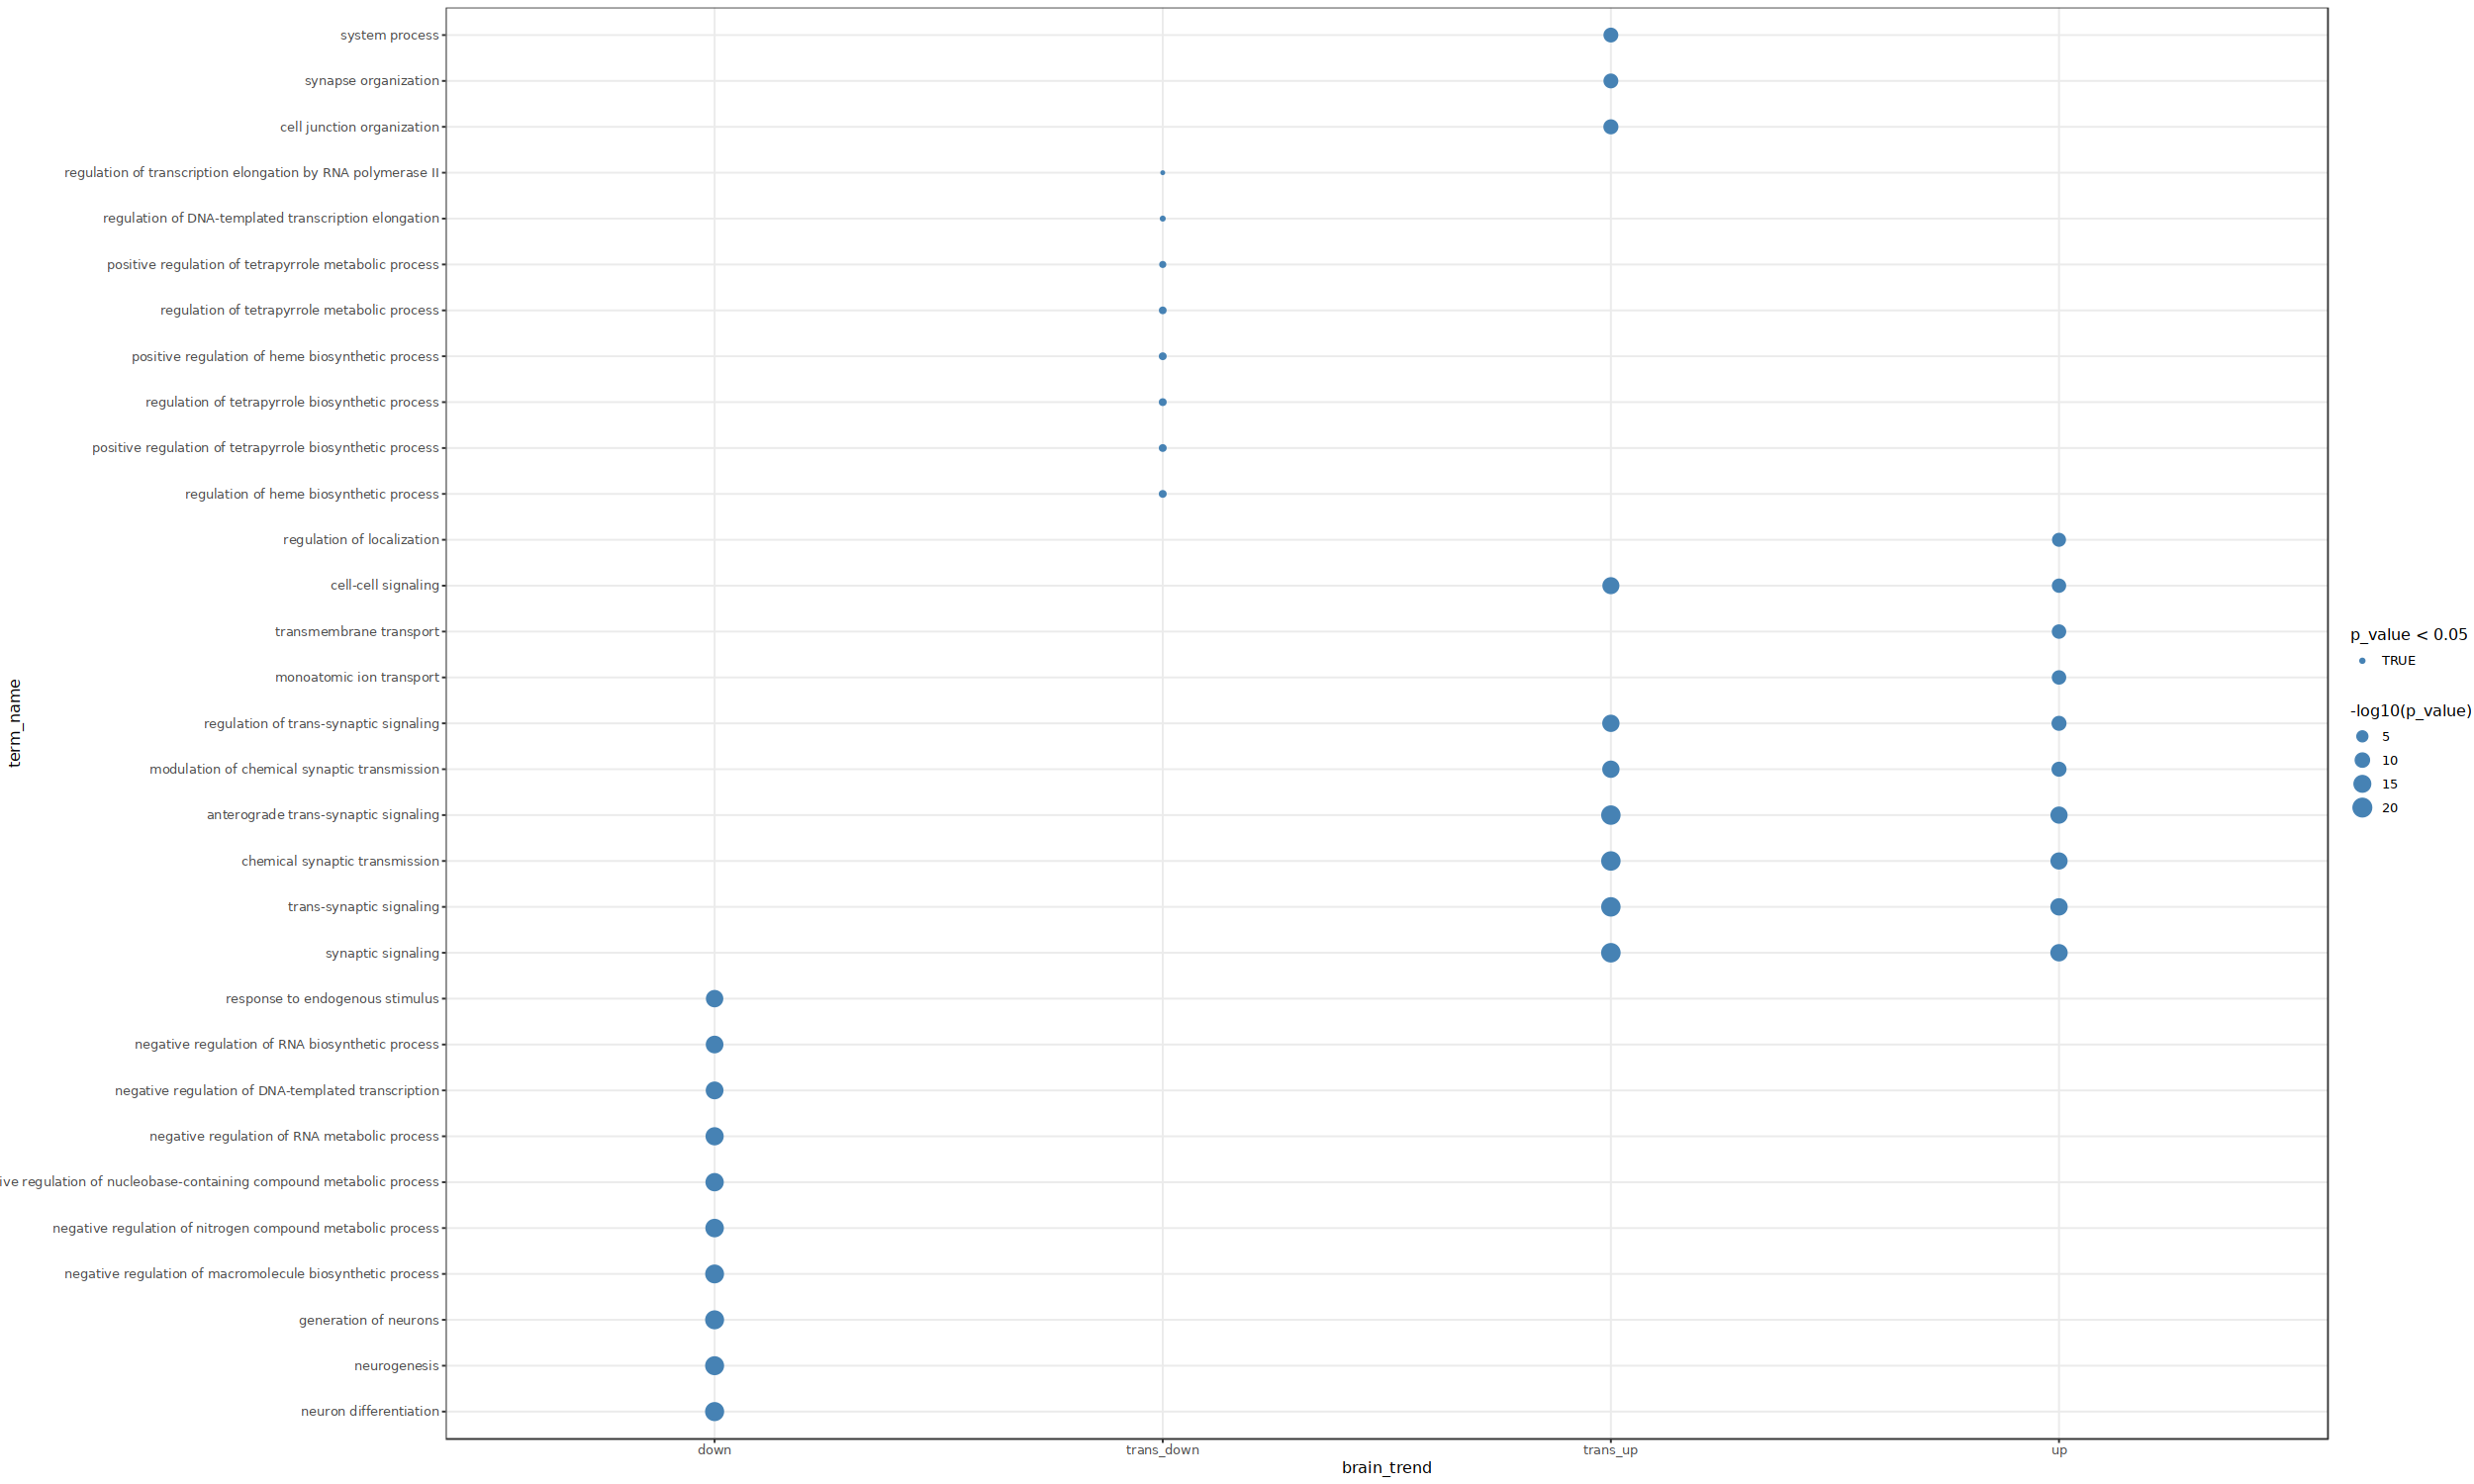

In [95]:
DEG_trend_brain_gobp <- lapply(DEG_trend_Brain, function(x) {df <-    gost(x, source='GO:BP',
                                                                           custom_bg = brain_bg,
                                                                           #evcodes = TRUE, 
                                                                           correction_method = "fdr",user_threshold=0.1,significant=F)$result %>%subset(term_size < 2000)  } )


DEG_trend_brain_gobps <- do.call(rbind,DEG_trend_brain_gobp)
DEG_trend_brain_gobps$brain_trend <- str_split(rownames(DEG_trend_brain_gobps),pattern = '\\.',simplify = T)[,1]
gobps_brain_sig <- subset(DEG_trend_brain_gobps, p_value < 0.05)

gobps_brain_sig <- gobps_brain_sig%>%group_by(brain_trend)%>%top_n(10, -p_value)

gobps_brain_sig$term_name <- factor(gobps_brain_sig$term_name, levels=unique(gobps_brain_sig$term_name))

ggplot(gobps_brain_sig, aes(x=brain_trend,y=term_name,size=-log10(p_value)))+
geom_point(aes(shape=p_value < 0.05),color='steelblue')+theme_bw()



In [119]:


subset(DEG_trend_brain_gobps,term_name=='cell death')
subset(DEG_trend_brain_gobps,term_name=='myelination')
subset(DEG_trend_brain_gobps,term_name=='dendrite development')
subset(DEG_trend_brain_gobps,term_name=='neuron apoptotic process')

subset(DEG_trend_Olf_gobps,term_name=='cell death')
subset(DEG_trend_Olf_gobps,term_name=='myelination')
subset(DEG_trend_Olf_gobps,term_name=='dendrite development')
subset(DEG_trend_Olf_gobps,term_name=='neuron apoptotic process')

# subset(DEG_trend_brain_gobps,grepl('neuron apoptotic process',term_name))
# subset(DEG_trend_Olf_gobps,grepl('neuron apoptotic process',term_name))


,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents,brain_trend
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>,<chr>
down.229,query_1,TRUE,5.058881e-06,1776,2921,346,0.11845258,0.19481982,GO:0008219,GO:BP,cell death,19304,3180,GO:0009987,down
up.1673,query_1,FALSE,4.294888e-01,1776,2179,219,0.10050482,0.12331081,GO:0008219,GO:BP,cell death,19304,3180,GO:0009987,up
trans_down.3634,query_1,FALSE,8.391697e-01,1776,498,44,0.08835341,0.02477477,GO:0008219,GO:BP,cell death,19304,3180,GO:0009987,trans_down
trans_up.185,query_1,TRUE,9.284598e-04,1776,969,127,0.13106295,0.07150901,GO:0008219,GO:BP,cell death,19304,3180,GO:0009987,trans_up


,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents,brain_trend
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>,<chr>
down.2867,query_1,FALSE,0.40370917,147,2921,28,0.009585758,0.19047619,GO:0042552,GO:BP,myelination,19304,10592,GO:0008366,down
up.241,query_1,TRUE,0.01574282,147,2179,31,0.014226709,0.21088435,GO:0042552,GO:BP,myelination,19304,10592,GO:0008366,up
trans_down.3234,query_1,FALSE,0.78966406,147,498,4,0.008032129,0.02721088,GO:0042552,GO:BP,myelination,19304,10592,GO:0008366,trans_down
trans_up.2294,query_1,FALSE,0.36499666,147,969,11,0.011351909,0.07482993,GO:0042552,GO:BP,myelination,19304,10592,GO:0008366,trans_up


,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents,brain_trend
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>,<chr>
down.608,query_1,TRUE,0.014014838,229,2921,53,0.01814447,0.23144105,GO:0016358,GO:BP,dendrite development,19304,5283,GO:00311....,down
up.255,query_1,TRUE,0.019187290,229,2179,43,0.01973382,0.18777293,GO:0016358,GO:BP,dendrite development,19304,5283,GO:00311....,up
trans_down.3290,query_1,FALSE,0.794402099,229,498,6,0.01204819,0.02620087,GO:0016358,GO:BP,dendrite development,19304,5283,GO:00311....,trans_down
trans_up.225,query_1,TRUE,0.002743445,229,969,26,0.02683179,0.11353712,GO:0016358,GO:BP,dendrite development,19304,5283,GO:00311....,trans_up


,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents,brain_trend
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>,<chr>
down.954,query_1,TRUE,0.061919300,255,2921,54,0.01848682,0.21176471,GO:0051402,GO:BP,neuron apoptotic process,19304,14150,GO:0006915,down
up.2478,query_1,FALSE,0.470670606,255,2179,35,0.01606241,0.13725490,GO:0051402,GO:BP,neuron apoptotic process,19304,14150,GO:0006915,up
trans_down.2322,query_1,FALSE,0.687739285,255,498,8,0.01606426,0.03137255,GO:0051402,GO:BP,neuron apoptotic process,19304,14150,GO:0006915,trans_down
trans_up.263,query_1,TRUE,0.005585978,255,969,27,0.02786378,0.10588235,GO:0051402,GO:BP,neuron apoptotic process,19304,14150,GO:0006915,trans_up


,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents,olf_trend
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>,<chr>
down.849,query_1,FALSE,0.1635710,1641,568,75,0.1320423,0.04570384,GO:0008219,GO:BP,cell death,15560,3180,GO:0009987,down
trans_up.900,query_1,FALSE,0.2782703,1641,369,49,0.1327913,0.02985984,GO:0008219,GO:BP,cell death,15560,3180,GO:0009987,trans_up
up.2321,query_1,FALSE,0.6861093,1641,729,82,0.1124829,0.04996953,GO:0008219,GO:BP,cell death,15560,3180,GO:0009987,up


,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents,olf_trend
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>,<chr>
down.2881,query_1,FALSE,0.4599358,135,568,7,0.01232394,0.05185185,GO:0042552,GO:BP,myelination,15560,10592,GO:0008366,down
trans_up.1353,query_1,FALSE,0.3498686,135,369,6,0.01626016,0.04444444,GO:0042552,GO:BP,myelination,15560,10592,GO:0008366,trans_up
up.728,query_1,FALSE,0.4071554,135,729,11,0.01508916,0.08148148,GO:0042552,GO:BP,myelination,15560,10592,GO:0008366,up


,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents,olf_trend
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>,<chr>
down.1129,query_1,FALSE,0.187329125,223,568,14,0.02464789,0.06278027,GO:0016358,GO:BP,dendrite development,15560,5283,GO:00311....,down
trans_up.59,query_1,TRUE,0.001892658,223,369,17,0.04607046,0.07623318,GO:0016358,GO:BP,dendrite development,15560,5283,GO:00311....,trans_up
up.1677,query_1,FALSE,0.589294078,223,729,14,0.01920439,0.06278027,GO:0016358,GO:BP,dendrite development,15560,5283,GO:00311....,up


,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents,olf_trend
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>,<chr>
down.2244,query_1,FALSE,0.3668702,231,568,12,0.02112676,0.05194805,GO:0051402,GO:BP,neuron apoptotic process,15560,14150,GO:0006915,down
trans_up.2627,query_1,FALSE,0.5455160,231,369,7,0.01897019,0.03030303,GO:0051402,GO:BP,neuron apoptotic process,15560,14150,GO:0006915,trans_up
up.311,query_1,FALSE,0.2284145,231,729,19,0.02606310,0.08225108,GO:0051402,GO:BP,neuron apoptotic process,15560,14150,GO:0006915,up


[1] "olf"      "trans_up"


preparing gene to GO mapping data...

preparing IC data...

Warning message in calculateSimMatrix(go_analysis$term_id, orgdb = "org.Hs.eg.db", :
“Removed 1 terms that were not found in orgdb for BP”
'select()' returned 1:many mapping between keys and columns



[1] "brain"    "trans_up"


preparing gene to GO mapping data...

preparing IC data...

Warning message in calculateSimMatrix(go_analysis$term_id, orgdb = "org.Hs.eg.db", :
“Removed 2 terms that were not found in orgdb for BP”
'select()' returned 1:many mapping between keys and columns



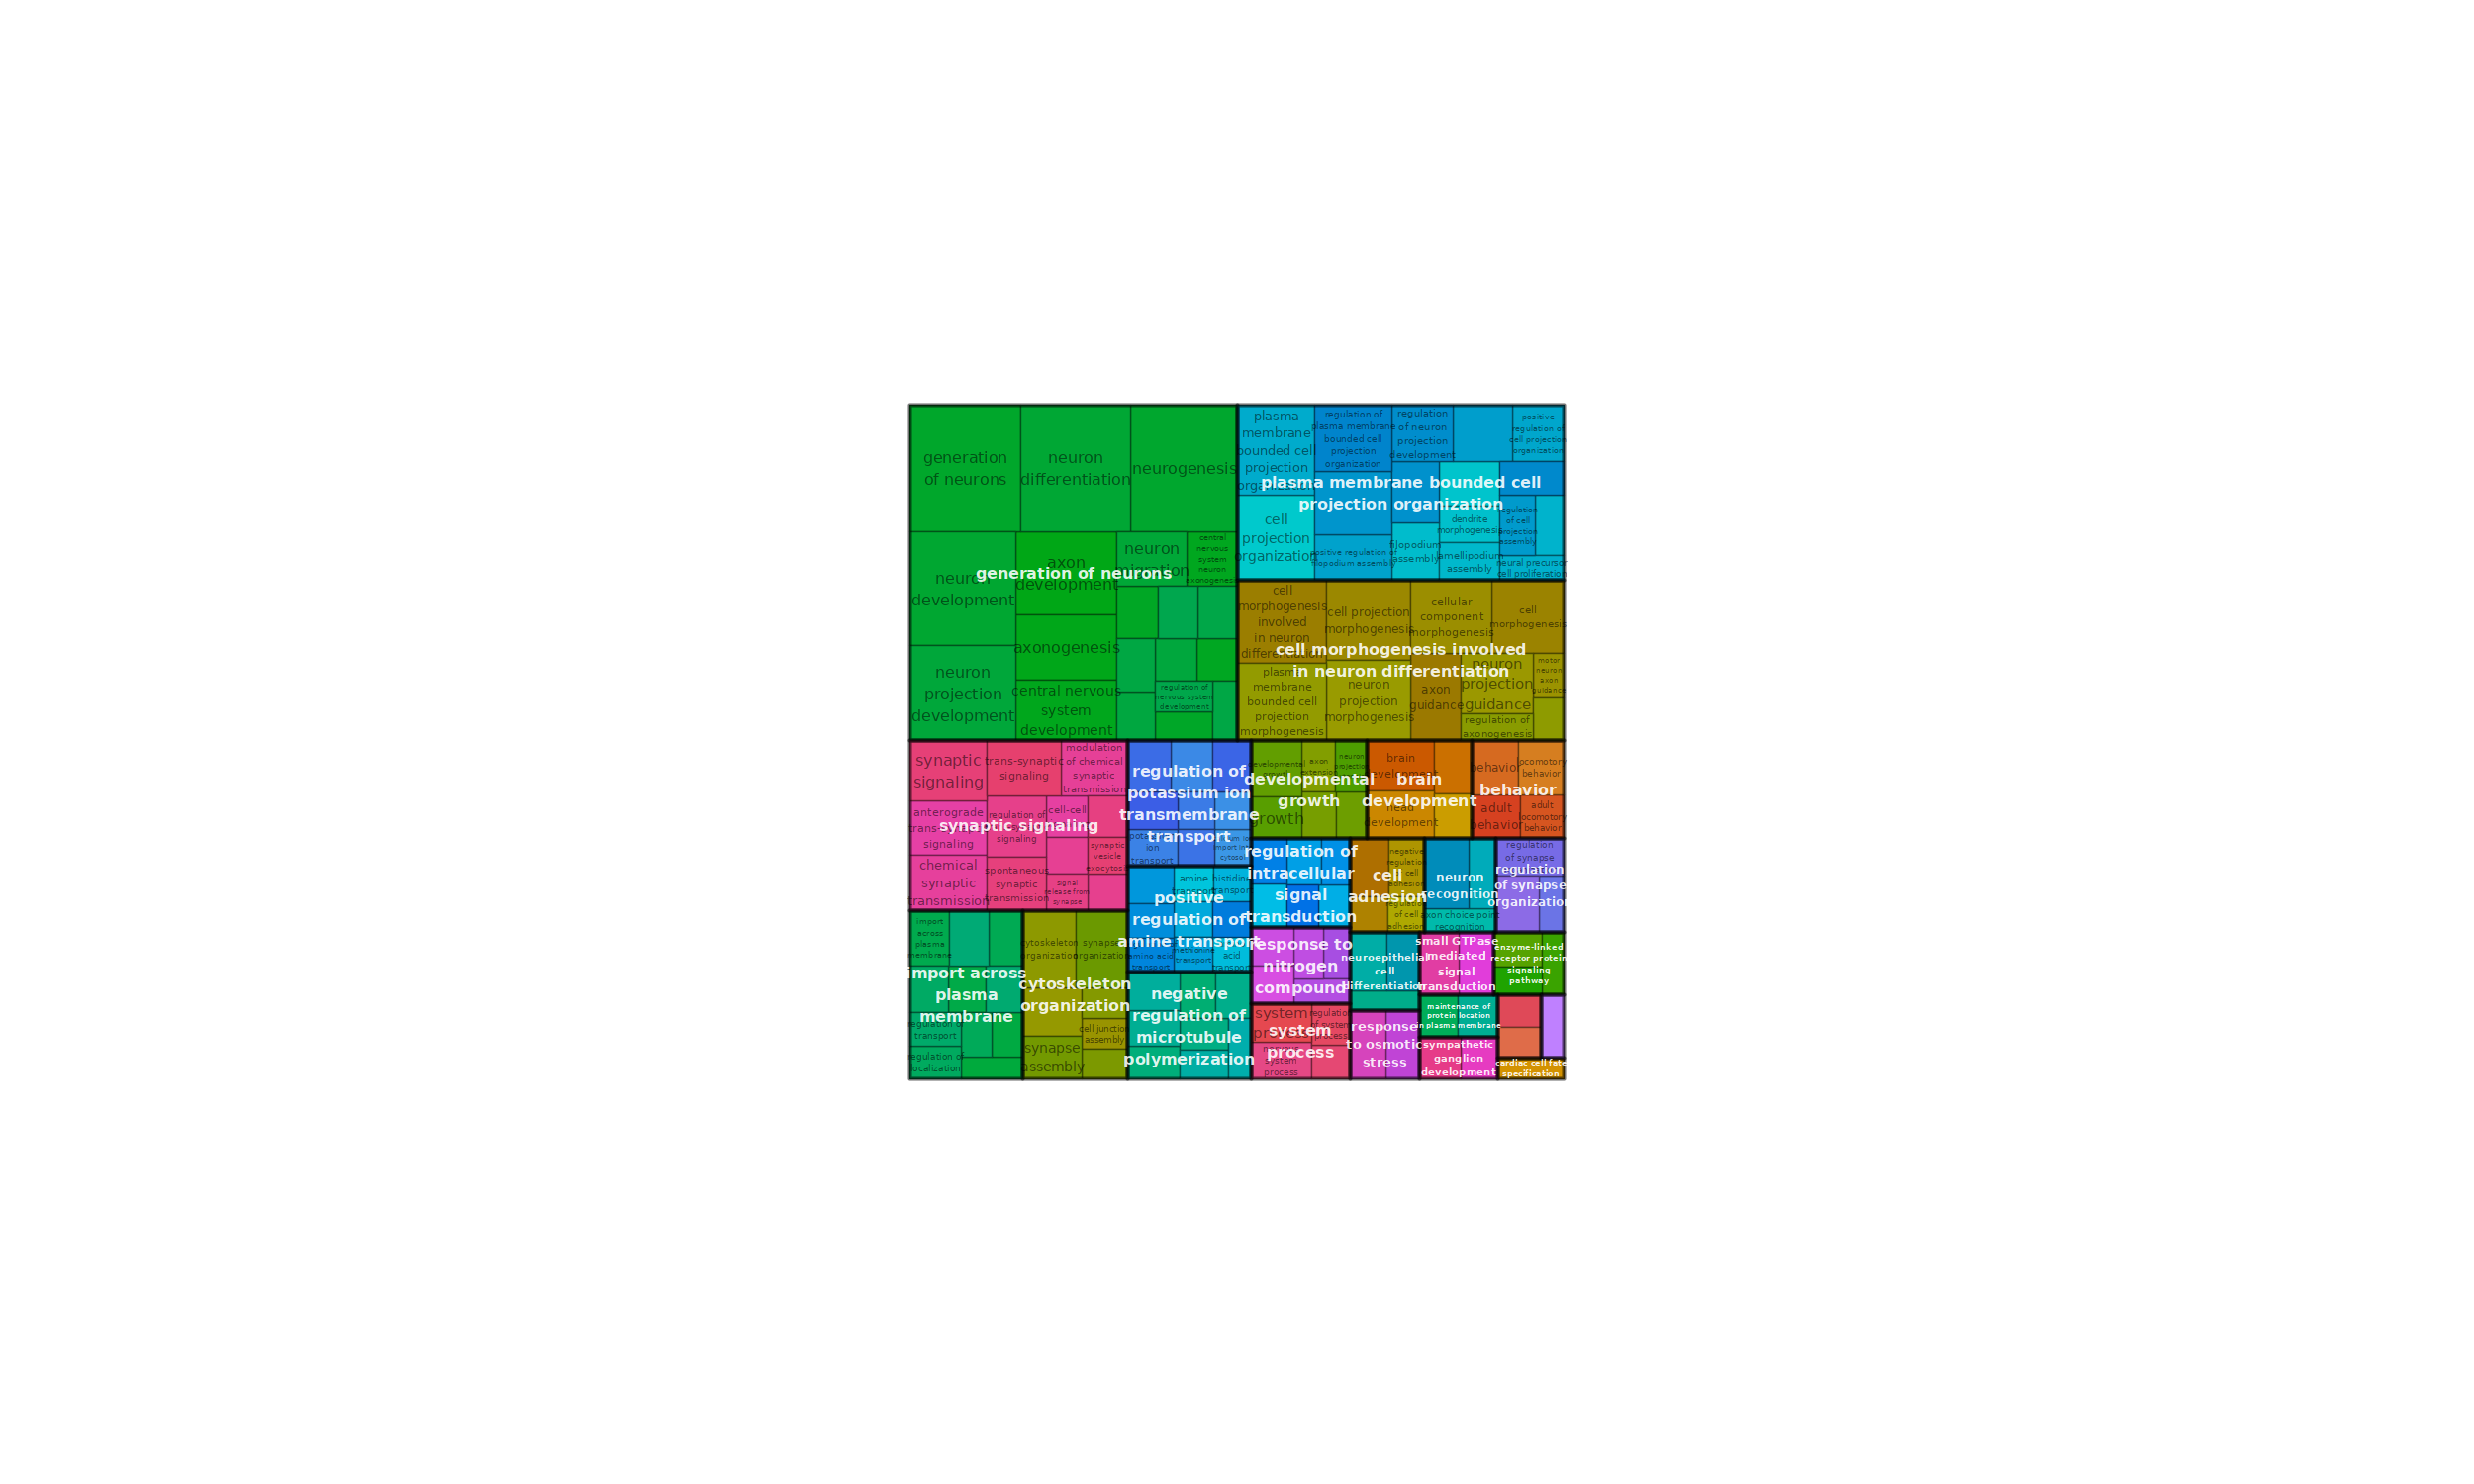

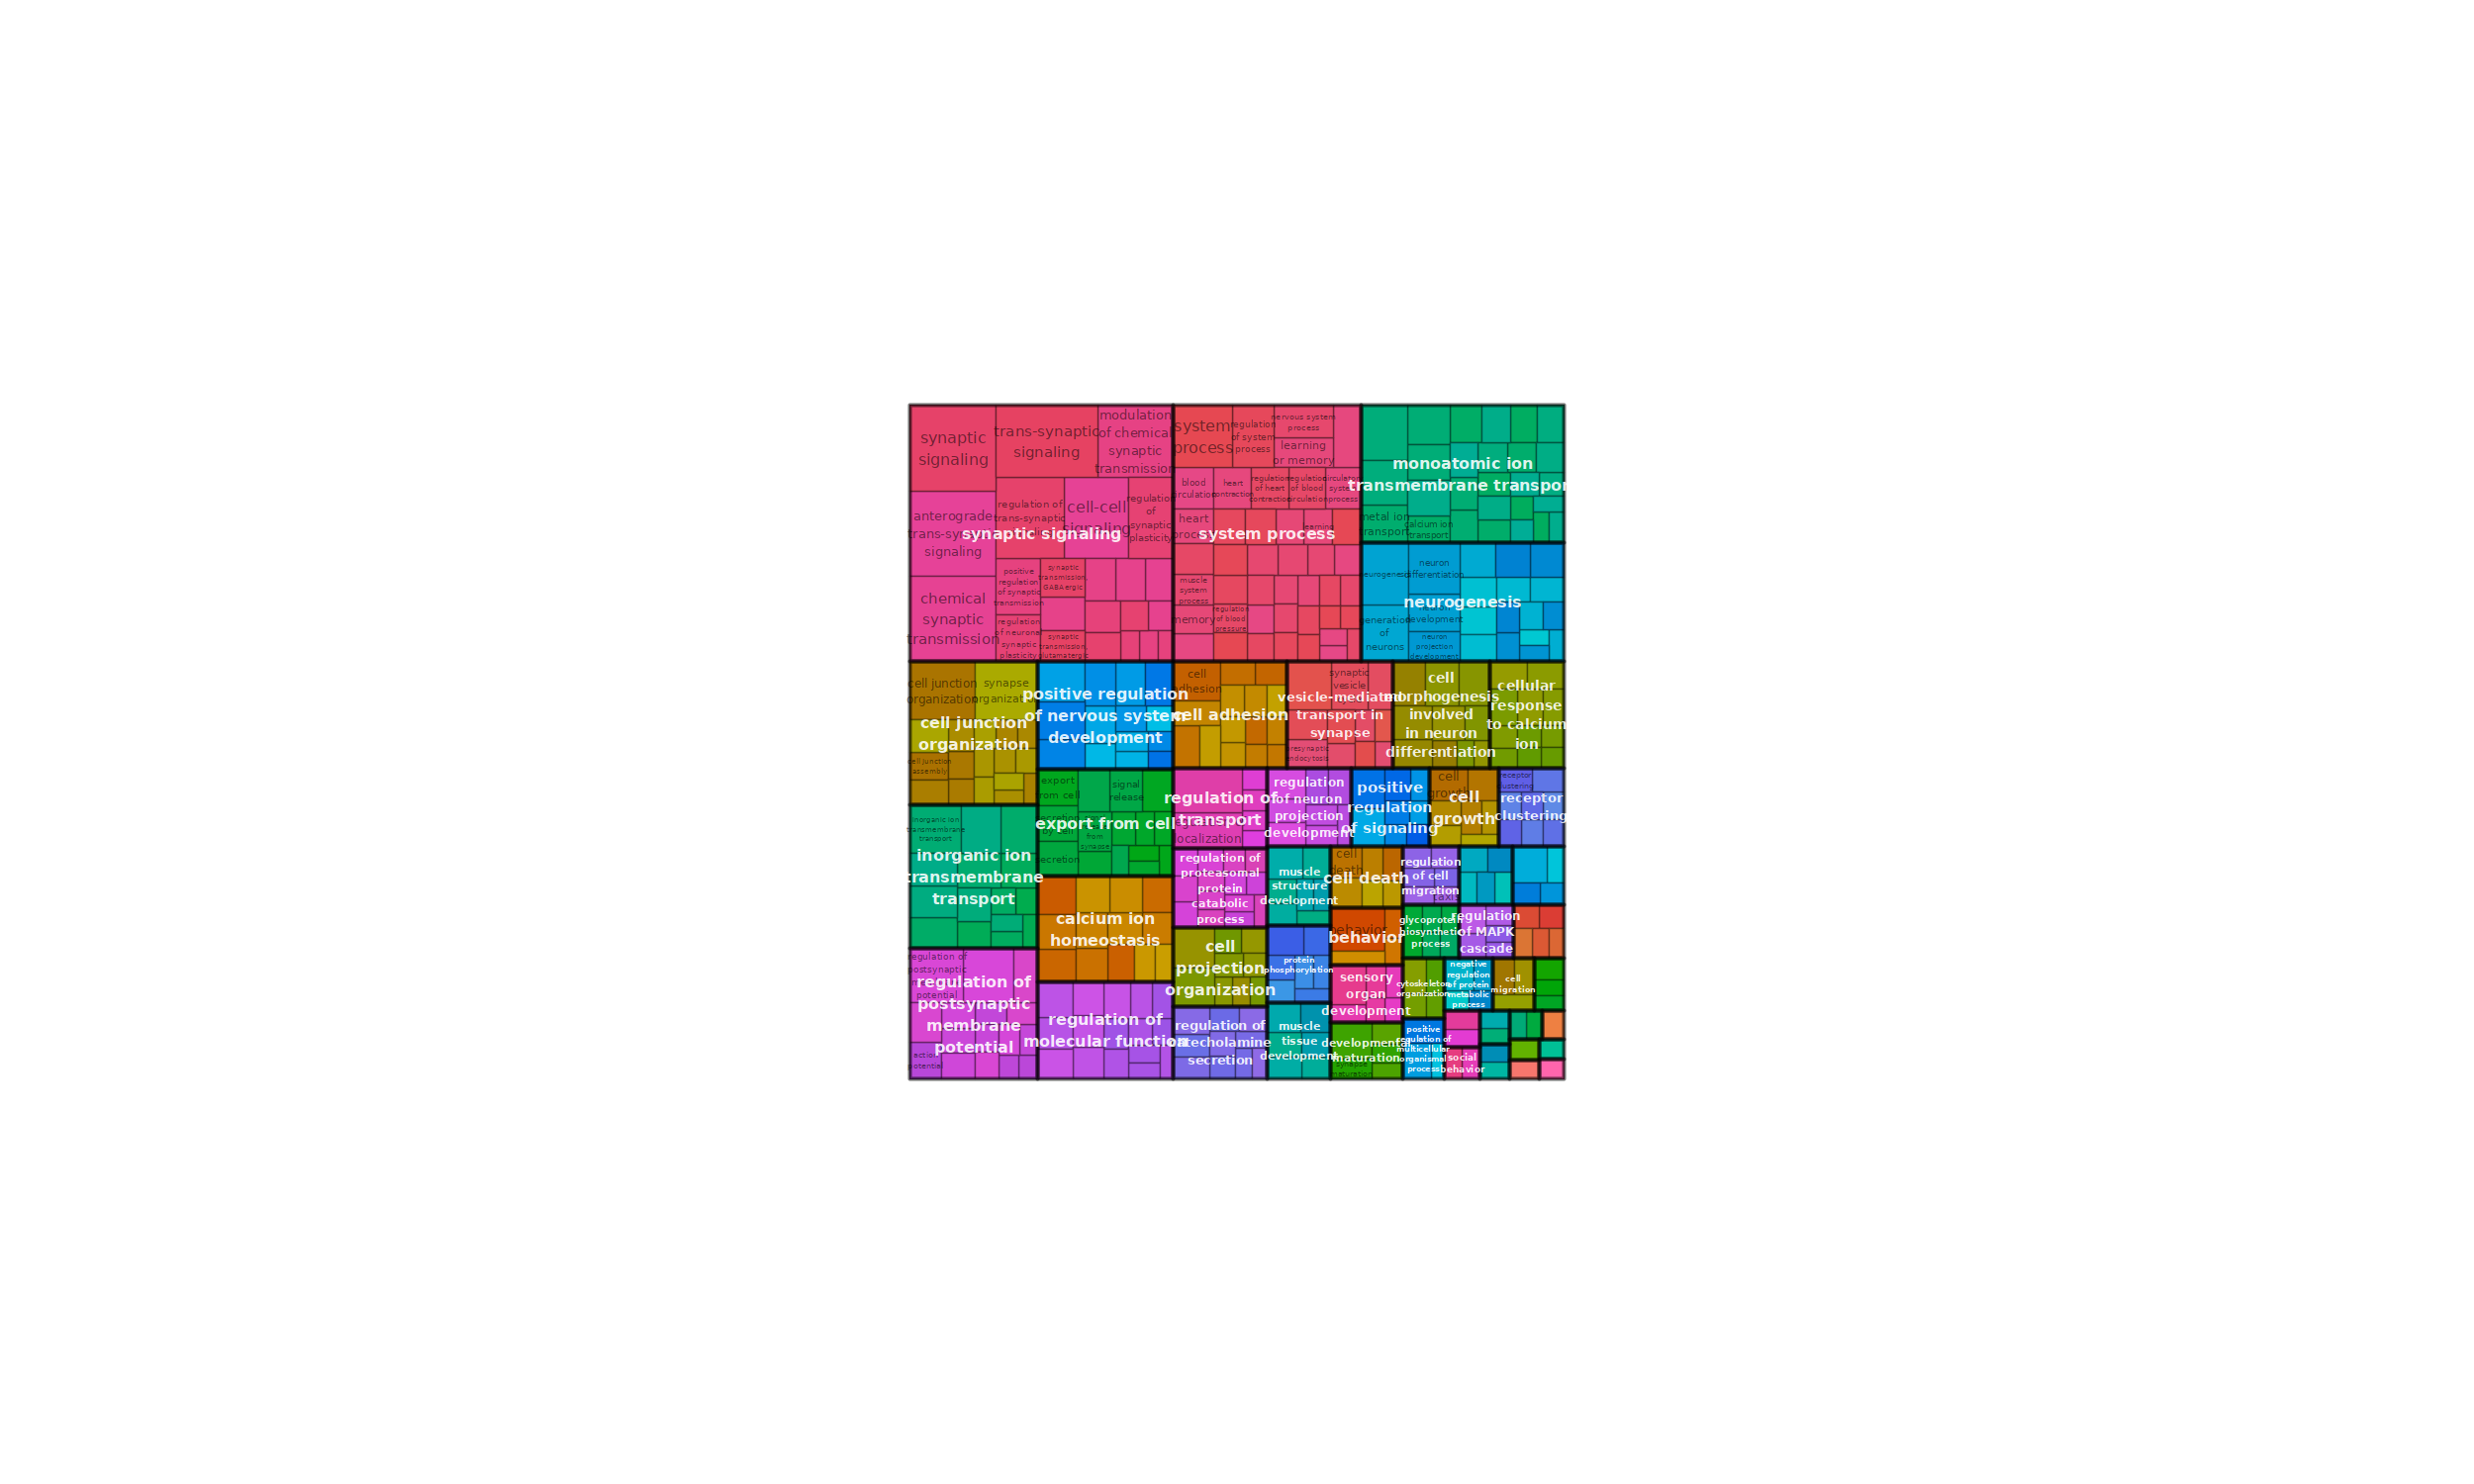

In [97]:

library(rrvgo)

get_bp_enrichr_reducedTerms <- function(trend,overlap,go_analysis){
  #go_analysis$GOID <- str_split(go_analysis$Term,'\\(|\\)',simplify = T)[,2]
  simMatrix <- calculateSimMatrix(go_analysis$term_id,
                                  orgdb="org.Hs.eg.db",
                                  ont="BP",
                                  method="Rel")
  
  
  scores <- setNames(-log10(as.numeric(go_analysis$p_value)), go_analysis$term_id)
  reducedTerms <- reduceSimMatrix(simMatrix,
                                  scores,
                                  orgdb="org.Hs.eg.db")
  
  treemapPlot(reducedTerms)
  
}


go_terms_genelevel <- c()
for(trend in c('trans_up')){#,'trans_up','trans_down'
    
  for (overlp in c('olf','brain')){

    
   # if(overlp=='overlap'){GO_analysis=subset(gobps_devDEG, p_value < 0.05 & olf_trend==trend & brain_trend==trend); print(c(overlp,trend  ))}
    if(overlp=='olf'){GO_analysis=subset(DEG_trend_Olf_gobps, p_value < 0.05 & olf_trend==trend );  print(c(overlp,trend  ))}
    if(overlp=='brain'){GO_analysis=subset(DEG_trend_brain_gobps, p_value < 0.05 & brain_trend==trend);  print(c(overlp,trend  ))}
    go_term <- c()
    if(nrow(GO_analysis) >=5 ){
            go_term <- get_bp_enrichr_reducedTerms(trend,overlp,GO_analysis)
    }

  }
}



In [126]:
library(ggrepel)
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)

#DEG_trend_Brain
get_bp_enrichr_reducedTerms <- function(go_analysis){
  #go_analysis$GOID <- str_split(go_analysis$Term,'\\(|\\)',simplify = T)[,2]
  simMatrix <- calculateSimMatrix(go_analysis$term_id,
                                  orgdb="org.Hs.eg.db",
                                  ont="BP",
                                  method="Rel")
  
  
  scores <- setNames(-log10(as.numeric(go_analysis$p_value.x)), go_analysis$term_id)
  reducedTerms <- reduceSimMatrix(simMatrix,
                                  scores,
                                  orgdb="org.Hs.eg.db")

  return(reducedTerms)
  
}


getDEG_gobps_top_rrvgo <- function(trend){
    print(trend)
  DEG_gobps <- merge(DEG_trend_Olf_gobps[DEG_trend_Olf_gobps$olf_trend==trend,c('term_id','term_name','olf_trend','p_value')], 
                     DEG_trend_brain_gobps[DEG_trend_brain_gobps$brain_trend==trend,c('term_id','term_name','brain_trend','p_value')],
                     by=c('term_id','term_name'))#, all.x=T, all.y=T
  
  DEG_gobps_top <- rbind(DEG_gobps%>%top_n(10, -p_value.x), 
                         DEG_gobps%>%top_n(10, -p_value.y),#,'dendrite development'
                         subset(DEG_gobps,term_name%in%c('neuron apoptotic process','myelination') & (p_value.x < 0.05|p_value.y < 0.05)))
  DEG_gobps_top <- rbind(DEG_gobps_top[!duplicated(DEG_gobps_top$term_id),])


  
  top_rrvgo <- get_bp_enrichr_reducedTerms(DEG_gobps_top)
  
  
  DEG_gobps_top_rrvgo <- merge(DEG_gobps_top, top_rrvgo[,c('go','parentTerm')], by.x='term_id',by.y='go')
  return(DEG_gobps_top_rrvgo)
}


options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 100)

DEG_gobps_top_rrvgo_down <- getDEG_gobps_top_rrvgo('down')%>%mutate(term=ifelse(term_name==parentTerm, term_name, ''))
DEG_gobps_top_rrvgo_up <- getDEG_gobps_top_rrvgo('up')%>%mutate(term=ifelse(term_name==parentTerm, term_name, ''))
DEG_gobps_top_rrvgo_transup <- getDEG_gobps_top_rrvgo('trans_up')%>%mutate(term=ifelse(term_name==parentTerm, term_name, ''))
#DEG_gobps_top_rrvgo_transdown <- getDEG_gobps_top_rrvgo('trans_down')%>%mutate(term=ifelse(term_name==parentTerm, term_name, ''))


[1] "down"


preparing gene to GO mapping data...

preparing IC data...

'select()' returned 1:many mapping between keys and columns



[1] "up"


preparing gene to GO mapping data...

preparing IC data...

'select()' returned 1:many mapping between keys and columns



[1] "trans_up"


preparing gene to GO mapping data...

preparing IC data...

'select()' returned 1:many mapping between keys and columns



In [127]:
getwd()

[1] "/sc/arion/projects/roussp01a/liting/Olf"

In [128]:
library(RColorBrewer)
set1_colors <- brewer.pal(n = 8, name = "Set2")[-8]
set3_colors <- brewer.pal(n = 8, name = "Accent")[-4]
set2_colors <- brewer.pal(n = 12, name = "Paired")[-11]
c25 <- c(set1_colors,set2_colors, set3_colors)


parent_t <- unique(rbind(DEG_gobps_top_rrvgo_down,DEG_gobps_top_rrvgo_up, DEG_gobps_top_rrvgo_transup)$parentTerm)
parent_c <- c25[1:length(parent_t)]
names(parent_c) <- parent_t

color_values <- setNames((parent_c), (parent_t))


Warning message:
“Width not defined
ℹ Set with `position_dodge(width = ...)`”


pdf 
  2

Warning message:
“Width not defined
ℹ Set with `position_dodge(width = ...)`”


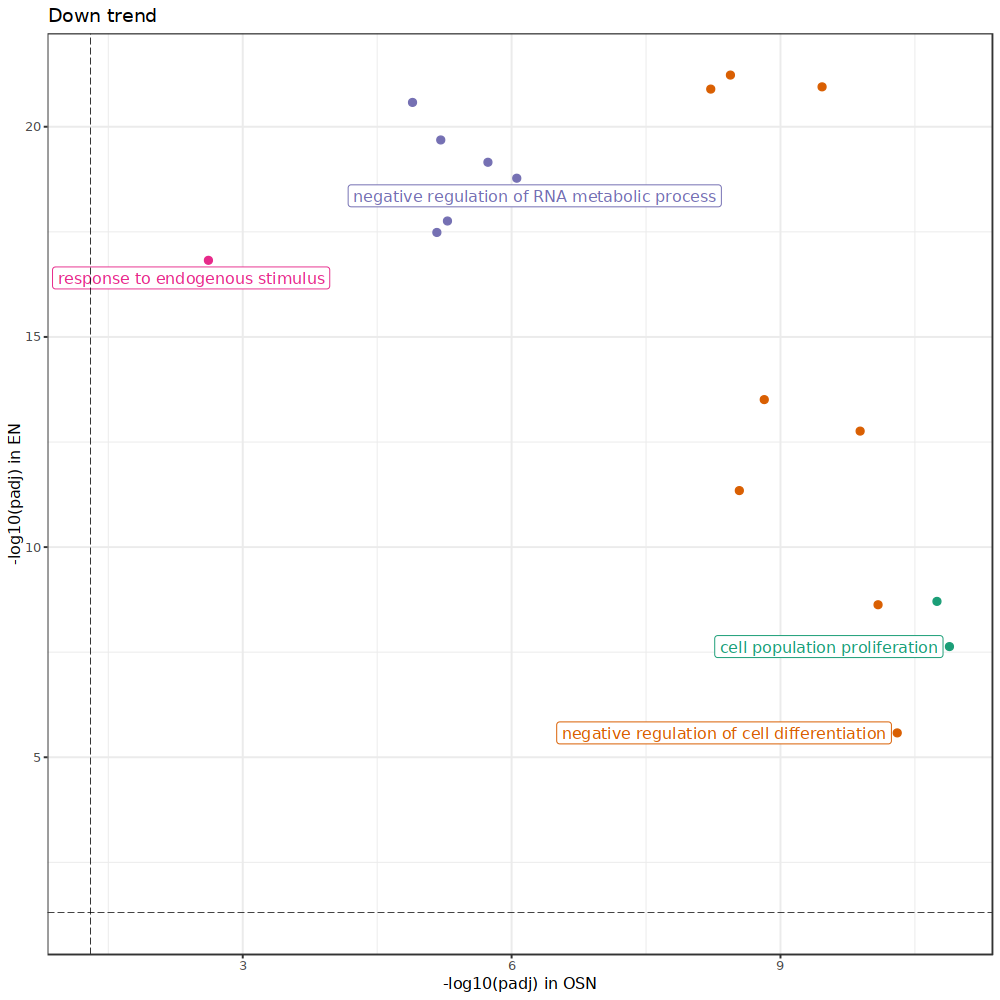

pdf 
  2

Warning message:
“Width not defined
ℹ Set with `position_dodge(width = ...)`”


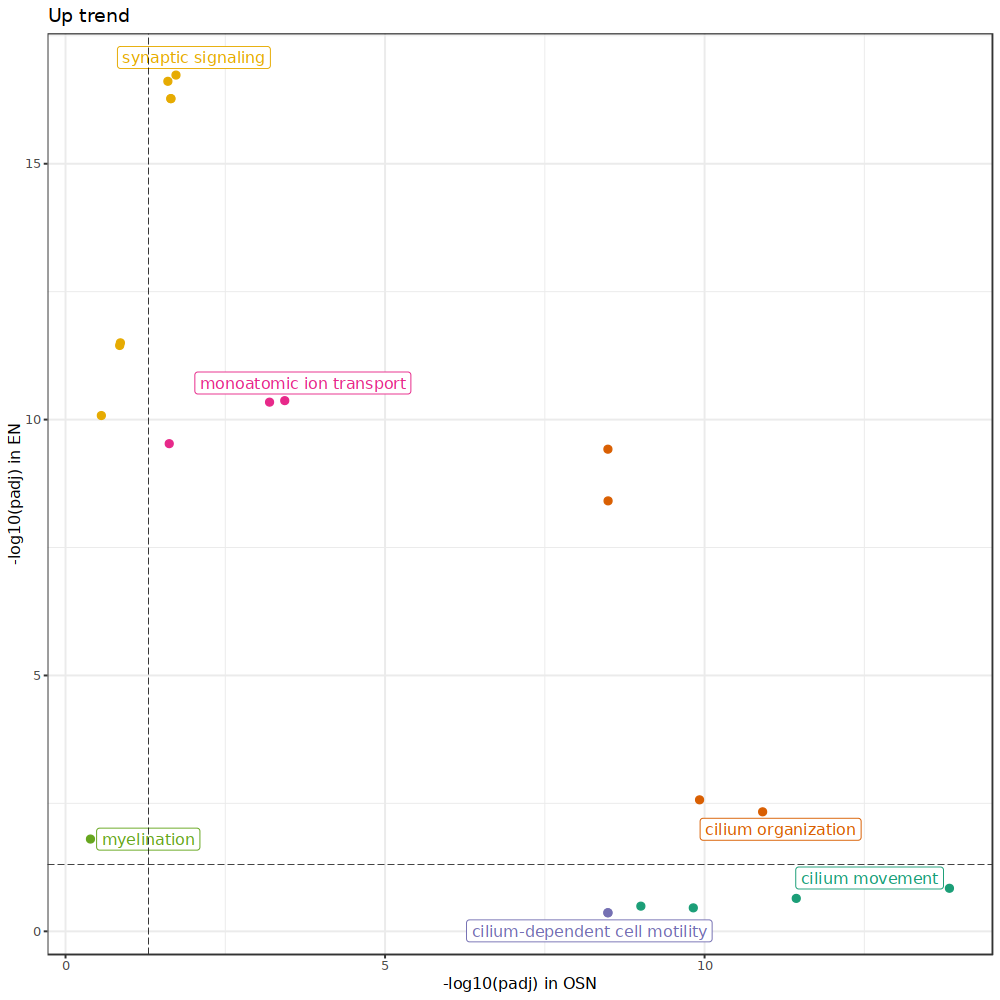

pdf 
  2

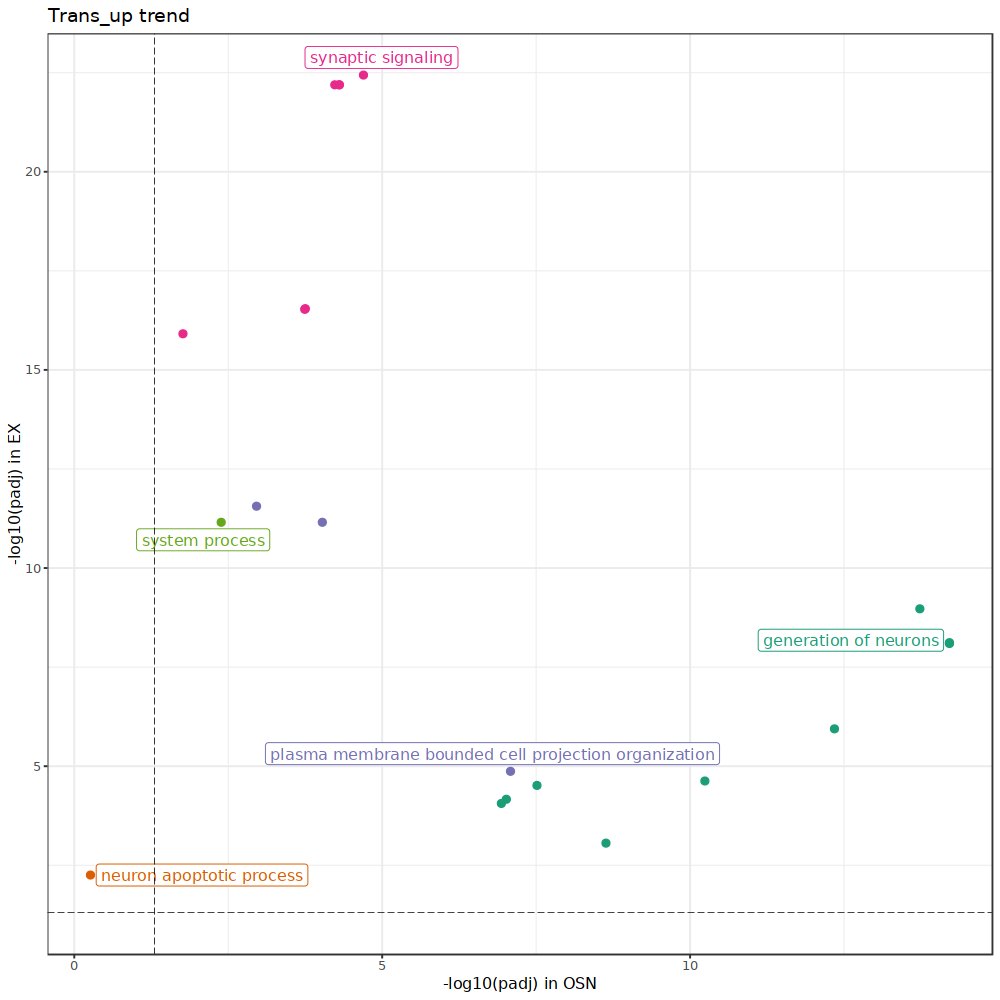

In [129]:

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)
ggplot(DEG_gobps_top_rrvgo_down,aes(x=-log10(p_value.x),y=-log10(p_value.y),color=parentTerm) )+geom_point(size=2)+
 #geom_label_repel(aes(label=term_name),position = "dodge")+
  geom_label_repel(aes(label=term),position = "dodge", max.overlaps=30)+
  geom_vline(xintercept = -log10(0.05), linetype = "longdash", lwd=0.2)+
  geom_hline(yintercept = -log10(0.05),linetype = "longdash", lwd=0.2)+
  theme_bw()+xlab('-log10(FDR) in OSN')+ylab('-log10(FDR) in EN')+ggtitle('Down trend')+
theme(legend.position='')+
scale_color_brewer(palette = "Dark2")#+
#geom_smooth(method = "loess", color = "blue") 
#scale_color_manual(values = color_values)

dev.print(pdf, file='./figures/DEG_gobps_top_rrvgo_down.pdf',width=5, height=5)

ggplot(DEG_gobps_top_rrvgo_up, aes(x=-log10(p_value.x),y=-log10(p_value.y),color=parentTerm) )+geom_point(size=2)+
 #geom_label_repel(aes(label=term_name),position = "dodge")+ 
  geom_label_repel(aes(label=term),position = "dodge", max.overlaps=30)+
  geom_vline(xintercept = -log10(0.05), linetype = "longdash", lwd=0.2)+
  geom_hline(yintercept = -log10(0.05),linetype = "longdash", lwd=0.2)+
  theme_bw()+xlab('-log10(FDR) in OSN')+ylab('-log10(FDR) in EN')+ggtitle('Up trend')+
theme(legend.position='')+
scale_color_brewer(palette = "Dark2")
dev.print(pdf, file='./figures/DEG_gobps_top_rrvgo_up.pdf',width=5, height=5)


ggplot(DEG_gobps_top_rrvgo_transup, aes(x=-log10(p_value.x),y=-log10(p_value.y),color=parentTerm) )+geom_point(size=2)+
# geom_label_repel(aes(label=term_name),position = "dodge",max.overlaps=20)+ 
 geom_label_repel(aes(label=term),position = "dodge", max.overlaps=30)+
  geom_vline(xintercept = -log10(0.05), linetype = "longdash", lwd=0.2)+
  geom_hline(yintercept = -log10(0.05),linetype = "longdash", lwd=0.2)+
theme(legend.position='')+
  theme_bw()+xlab('-log10(FDR) in OSN') + ylab('-log10(FDR) in EX') + ggtitle('Trans_up trend')+
theme(legend.position='')+
scale_color_brewer(palette = "Dark2")
dev.print(pdf, file='./figures/DEG_gobps_top_rrvgo_transup.pdf',width=5, height=5)


# ggplot(DEG_gobps_top_rrvgo_transdown,aes(x=-log10(p_value.x),y=-log10(p_value.y),color=parentTerm) )+geom_point(size=4)+
#  # geom_label_repel(aes(label=term_name),position = "dodge")+ for each term
#   geom_label_repel(aes(label=term),position = "dodge")+
#   geom_vline(xintercept = -log10(0.05), linetype = "longdash", lwd=0.2)+
#   geom_hline(yintercept = -log10(0.05),linetype = "longdash", lwd=0.2)+
#   theme_bw()

In [130]:
#DEG_gobps_top_rrvgo_down

Warning message:
“Width not defined
ℹ Set with `position_dodge(width = ...)`”


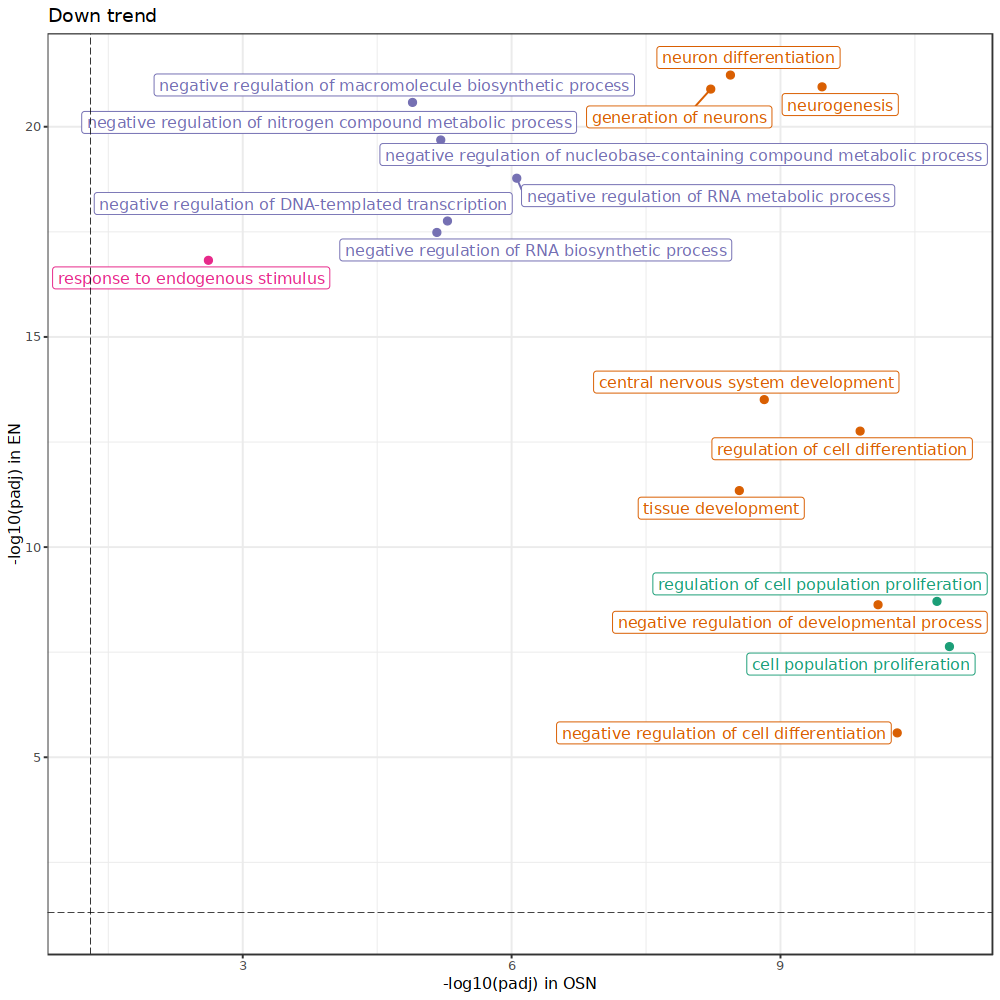

In [131]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)
ggplot(DEG_gobps_top_rrvgo_down,aes(x=-log10(p_value.x),y=-log10(p_value.y),color=parentTerm) )+geom_point(size=2)+
 geom_label_repel(aes(label=term_name),position = "dodge")+
  #geom_label_repel(aes(label=term),position = "dodge", max.overlaps=30)+
  geom_vline(xintercept = -log10(0.05), linetype = "longdash", lwd=0.2)+
  geom_hline(yintercept = -log10(0.05),linetype = "longdash", lwd=0.2)+
  theme_bw()+xlab('-log10(FDR) in OSN')+ylab('-log10(FDR) in EN')+ggtitle('Down trend')+
theme(legend.position='')+
scale_color_brewer(palette = "Dark2")#+
#geom_smooth(method = "loess", color = "blue") 
#scale_color_manual(values = color_values)



### plot traj for selected genes

### get terms & get genes

#### for olf neurons

In [132]:
# 1. neurogenesis
neurogenesis1 <- unlist(str_split(subset(DEG_trend_Olf_gobp$down, term_name=='neurogenesis')$intersection,','))
neurogenesis2 <- unlist(str_split(subset(DEG_trend_Olf_gobp$trans_up, term_name=='neurogenesis')$intersection,','))

# 2. neuron differentiation
neuron_differentiation1 <- unlist(str_split(subset(DEG_trend_Olf_gobp$down, term_name=='neuron differentiation')$intersection,','))
neuron_differentiation2 <- unlist(str_split(subset(DEG_trend_Olf_gobp$trans_up, term_name=='neuron differentiation')$intersection,','))

# 3. neuron projection development
neuron_projection_development1 <- unlist(str_split(subset(DEG_trend_Olf_gobp$down, term_name=='neuron projection development')$intersection,','))
neuron_projection_development2 <- unlist(str_split(subset(DEG_trend_Olf_gobp$trans_up, term_name== 'neuron projection development')$intersection,','))

# 4. axon development
axon_development1 <- unlist(str_split(subset(DEG_trend_Olf_gobp$down, term_name=='axon development')$intersection,','))
axon_development2 <- unlist(str_split(subset(DEG_trend_Olf_gobp$trans_up, term_name=='axon development')$intersection,','))

# 5. metal ion transport
#subset(DEG_trend_Olf_gobp$up, grepl('metal ion transport',term_name))[,1:12]
metal_ion_transport <- unlist(str_split(subset(DEG_trend_Olf_gobp$up, term_name=='metal ion transport')$intersection,','))

# 6. cilium organization
cilium_organization <- unlist(str_split(subset(DEG_trend_Olf_gobp$up, term_name=='cilium organization')$intersection,','))

# 6. cilium organization
neuron_apoptotic_process <-  unlist(str_split(subset(DEG_trend_Olf_gobp$up, term_name=='neuron apoptotic process')$intersection,','))

selected_gene_olf <- list(neurogenesis=c(neurogenesis1,neurogenesis2),
    neuron_differentiation=c(neuron_differentiation1,neuron_differentiation2),
    neuron_projection_development=c(neuron_projection_development1,neuron_projection_development2),
                         axon_development=c(axon_development1, axon_development2),
                         metal_ion_transport=metal_ion_transport,
                         cilium_organization=cilium_organization,
                          neuron_apoptotic_process=neuron_apoptotic_process
)

names(selected_gene_olf) <- str_to_title(names(selected_gene_olf))

In [17]:
subset(DEG_trend_Olf_gobp$down, term_name=='neuron projection development')[,1:12]
subset(DEG_trend_Olf_gobp$trans_up, term_name=='neuron projection development')[,1:12]

,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
106,query_1,TRUE,5.136742e-05,921,572,61,0.1066434,0.06623236,GO:0031175,GO:BP,neuron projection development,16452


,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
6,query_1,TRUE,2.058401e-11,921,372,61,0.1639785,0.06623236,GO:0031175,GO:BP,neuron projection development,16452


#### for brain specific 

In [18]:
subset(DEG_trend_brain_gobp$up, grepl('myelination',term_name))[,1:12]

ensheathment_of_neurons <- unlist(str_split(subset(DEG_trend_brain_gobp$up, grepl('ensheathment of neurons',term_name))$intersection,','))

learning_or_memory <- unlist(str_split(subset(DEG_trend_brain_gobp$trans_up, term_name=='learning or memory')$intersection,','))

neuron_apoptotic_process <- unlist(str_split(subset(DEG_trend_brain_gobp$trans_up, term_name=='neuron apoptotic process')$intersection,','))

synapse_organization <- unlist(str_split(subset(DEG_trend_brain_gobp$trans_up, term_name=='synapse organization')$intersection,','))

myelination <- unlist(str_split(subset(DEG_trend_brain_gobp$trans_up, term_name=='myelination')$intersection,','))

selected_gene_brain <- list(ensheathment_of_neurons=ensheathment_of_neurons,
            learning_or_memory=learning_or_memory,
            #neuron_apoptotic_process=neuron_apoptotic_process,
                         synapse_organization=synapse_organization,
                            myelination=myelination
)

names(selected_gene_brain) <- str_to_title(names(selected_gene_brain))

,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
99,query_1,TRUE,0.007477774,25,2179,11,0.005048187,0.4400000,GO:0022010,GO:BP,central nervous system myelination,17702
217,query_1,TRUE,0.073685840,147,2179,31,0.014226709,0.2108844,GO:0042552,GO:BP,myelination,17702
2926,query_1,FALSE,0.662112650,26,2179,5,0.002294631,0.1923077,GO:0022011,GO:BP,myelination in peripheral nervous system,17702
4240,query_1,FALSE,0.754581854,17,2179,3,0.001376778,0.1764706,GO:0031643,GO:BP,positive regulation of myelination,17702
5407,query_1,FALSE,0.815694086,44,2179,6,0.002753557,0.1363636,GO:0031641,GO:BP,regulation of myelination,17702


In [19]:
get_pc_exp <- function(DEGs){

    load('./data/scdata.RData') 
pseudoTime <- scdata$monocle3_pseudotime
pt.matrix <- as.matrix(scdata@assays$RNA@data[,order(pseudoTime)])
overlap_DEGs <- intersect(DEGs, rownames(pt.matrix))
  pt.matrix <- pt.matrix[overlap_DEGs,]
    
  pt.matrix <- t(apply(pt.matrix,1,function(x){smooth.spline(x,df=3)$y}))


    
xx <- prcomp(pt.matrix, center = F)
xx <- t(as.data.frame((xx$rotation[,'PC1'])))
xxx <- (xx-min(xx))/(max(xx)-min(xx))

    return(xxx)
}

# mean_selected_gene_brain <- do.call(rbind,lapply(selected_gene_brain,get_pc_exp ))
# mean_selected_gene_Olf <- do.call(rbind,lapply(selected_gene_olf,get_pc_exp ))
# rownames(mean_selected_gene_brain) <- names(selected_gene_brain)
# rownames(mean_selected_gene_Olf) <- names(selected_gene_olf)


In [20]:
get_mean_exp <- function(DEGs){

    load('./data/scdata.RData') 
pseudoTime <- scdata$monocle3_pseudotime
pt.matrix <- as.matrix(scdata@assays$RNA@data[,order(pseudoTime)])

    
    overlap_DEGs <- intersect(DEGs, rownames(pt.matrix))
  
  pt.matrix <- pt.matrix[overlap_DEGs,]
  
  pt.matrix <- t(apply(pt.matrix,1,function(x){smooth.spline(x,df=3)$y}))
  #pt.matrix <- t(apply(pt.matrix,1,function(x){(x-mean(x))/sd(x)}))
  #pt.matrix <- t(apply(pt.matrix,1,function(x){(x-min(x))/(max(x)-min(x))}))

  
  rownames(pt.matrix) <- overlap_DEGs
  colnames(pt.matrix) <- colnames(scdata)[order(pseudoTime)]

  #print(pt.matrix)
  #pt.matrix_melt <- melt(pt.matrix)
  #pt.matrix_melt$pseudoTime <- scdata@meta.data[pt.matrix_melt$Var2,'monocle3_pseudotime']
  
  #xx <- subset(pt.matrix_melt,Var1=='DRAXIN')
  
  # ggplot(pt.matrix_melt, aes(x=pseudoTime, y=value, group=Var1)) +
  #     geom_smooth(method = "loess",se = F)+
  #     xlab('Pseudotime')+ylab('Expression')+theme_bw()
  pt.matrix <- pt.matrix[!rowSums(is.na(pt.matrix))>0,]

  meanexp <-  t(as.data.frame(colMeans(pt.matrix)))
    return(meanexp)
}

# get mean expression 
mean_selected_gene_brain <- do.call(rbind,lapply(selected_gene_brain,get_mean_exp ))
mean_selected_gene_Olf <- do.call(rbind,lapply(selected_gene_olf,get_mean_exp ))
rownames(mean_selected_gene_brain) <- names(selected_gene_brain)
rownames(mean_selected_gene_Olf) <- names(selected_gene_olf)


In [21]:
Nstage_color <- c('#1f77b4','#FDBF6F','#ff7f0e',"#298c8c")
names(Nstage_color) <- c('GBC','e_iOSN','l_iOSN','mOSN')


In [106]:
  #  load('./data/scdata.RData') 
#scdata@meta.data cca_N_types_stage cca_N_types


In [135]:
png(filename = './figures/07heatmap_EN.png', width = 15, height = 7, units = "cm", res=300)

library(ComplexHeatmap)
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 100)

ComplexHeatmap::draw(Heatmap(
   mean_selected_gene_brain,
      name = "Expression   ",
      column_title = 'EN-specific developmental processes',
      cluster_columns              = F,
      cluster_rows              = F,
        col    = colorRamp2(seq(from=0,to=1,length=11),rev(brewer.pal(11, "Spectral"))),

    show_row_names               = T,
    show_column_names            = FALSE,
    show_row_dend = F,
      top_annotation = HeatmapAnnotation(
     # cell_identity=scdata@meta.data[colnames(mean_selected_gene_brain),'cca_N_types'],
          cell_stage = factor(scdata@meta.data[colnames(mean_selected_gene_brain),'cca_N_types_stage'], levels=c('GBC','e_iOSN','l_iOSN','mOSN')),
      #batch=scdata@meta.data[colnames(pt.matrix),'batch'],
      #subc=scdata@meta.data[colnames(pt.matrix),'N_leiden_res0_2'],
      #pseudotime=sort(pseudoTime),
      col = list(#cell_identity =N_color,
                 cell_stage=Nstage_color ,
                 pseudotime= colorRamp2(c(0, 15 ,30), c("white","#8700A8","#35008C"))
      )
    )),    heatmap_legend_side = "bottom", annotation_legend_side = "bottom",merge_legend = TRUE)

dev.off()


pdf 
  2

In [137]:

png(filename = './figures/07heatmap_OSN.png', width = 15, height = 8, units = "cm", res=300)

  ComplexHeatmap::draw(Heatmap(
   mean_selected_gene_Olf,
      name = "expression",
      column_title = 'OSN develomental processes',
      cluster_columns              = F,
      cluster_rows              = F,
        col    = colorRamp2(seq(from=0,to=1,length=11),rev(brewer.pal(11, "Spectral"))),

    show_row_names               = T,
    show_column_names            = FALSE,
    show_row_dend = F,
      top_annotation = HeatmapAnnotation(
     # cell_identity=scdata@meta.data[colnames(mean_selected_gene_brain),'cca_N_types'],
          cell_stage = factor(scdata@meta.data[colnames(mean_selected_gene_brain),'cca_N_types_stage'], levels=c('GBC','e_iOSN','l_iOSN','mOSN')),
      #batch=scdata@meta.data[colnames(pt.matrix),'batch'],
      #subc=scdata@meta.data[colnames(pt.matrix),'N_leiden_res0_2'],
      #pseudotime=sort(pseudoTime),
      col = list(#cell_identity =N_color,
                 cell_stage=Nstage_color ,
                 pseudotime= colorRamp2(c(0, 15 ,30), c("white","#8700A8","#35008C"))
      )
    )),    heatmap_legend_side = "bottom", annotation_legend_side = "bottom",merge_legend = TRUE)
                       
dev.off()
  

pdf 
  2

### plot_heatmap_trend

In [460]:
options(repr.plot.width = 10, repr.plot.height = 2, repr.plot.res = 100)

library(stringr)
library(ggplot2)
library(reshape2)
library(ComplexHeatmap)
library(ggpubr)

load('./data/scdata.RData') 
pseudoTime <- scdata$monocle3_pseudotime
pt.matrix <- as.matrix(scdata@assays$RNA@counts[,order(pseudoTime)])


scdata$N_types_stage <- scdata$cca_N_types_stage

Nstage_color <- c('#1f77b4','#FDBF6F','#ff7f0e',"#298c8c")
names(Nstage_color) <- c('GBC','e_iOSN','l_iOSN','mOSN')


plot_heatmap_trend <- function(DEGs,trend){
  
  overlap_DEGs <- intersect(DEGs, rownames(pt.matrix))
  
  pt.matrix <- pt.matrix[overlap_DEGs,]
  
  pt.matrix <- t(apply(pt.matrix,1,function(x){smooth.spline(x,df=3)$y}))
  #pt.matrix <- t(apply(pt.matrix,1,function(x){(x-mean(x))/sd(x)}))
  #pt.matrix <- t(apply(pt.matrix,1,function(x){(x-min(x))/(max(x)-min(x))}))

  
  rownames(pt.matrix) <- overlap_DEGs
  colnames(pt.matrix) <- colnames(scdata)[order(pseudoTime)]

  pt.matrix <- pt.matrix[!rowSums(is.na(pt.matrix))>0,]

  plot(Heatmap(
    pt.matrix,name = "expression",
      column_title = trend,
      cluster_columns              = F,
      cluster_rows              = T,
        col    = colorRamp2(seq(from=0,to=5,length=11),rev(brewer.pal(11, "Spectral"))),

    show_row_names               = FALSE,
    show_column_names            = FALSE,
    show_row_dend = F,
#       top_annotation = HeatmapAnnotation(
#       cell_identity=scdata@meta.data[colnames(pt.matrix),'N_types'],
#           cell_subcluster = scdata@meta.data[colnames(pt.matrix),'N_types_stage'],
#       #batch=scdata@meta.data[colnames(pt.matrix),'batch'],
#       #subc=scdata@meta.data[colnames(pt.matrix),'N_leiden_res0_2'],
#       pseudotime=sort(pseudoTime),
#       col = list(cell_identity =N_color,cell_subcluster=Nstage_color ,
#                  pseudotime= colorRamp2(c(0, 15 ,30), c("white","#8700A8","#35008C"))
#       )
#     )
  ))
    
    
  
  g_mean <- as.data.frame(cbind(colMeans(pt.matrix,na.rm = T),sort(pseudoTime)))
  g_mean$cell_type=scdata@meta.data[rownames(g_mean),'N_types_stage']
  
plot1 <-  ggplot(g_mean, aes(V2, V1)) +
          geom_smooth(method = "loess",formula = y~x)+
          xlab('Pseudotime')+ylab('Expression')+theme_bw()#+
          #ggtitle(trend)

plot2 <- ggplot(g_mean) +
          xlab('celltype')+ylab('')+theme_void()+
          theme(legend.position='top')+
          geom_jitter( aes(x=V2,y=1,color=cell_type),size=2,height = 0.01)+
    scale_color_manual(values =  c('#1f77b4','#FDBF6F','#ff7f0e','#2ca02c'),breaks = c('GBC','e_iOSN','l_iOSN','mOSN'))



#plot(ggarrange(plot2, plot1, nrow = 2, heights = c(1, 7), align = 'hv'))
    plot(plot1)
 }

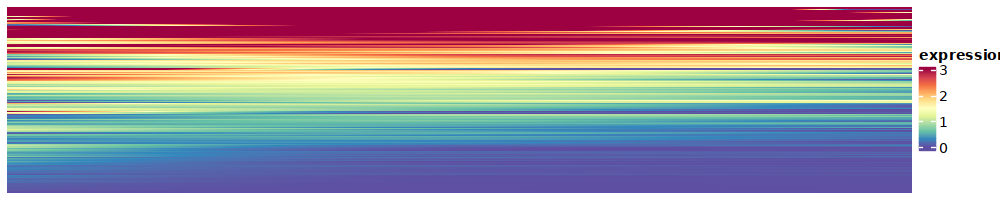

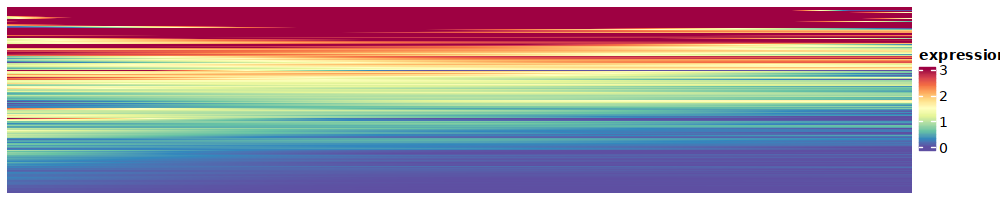

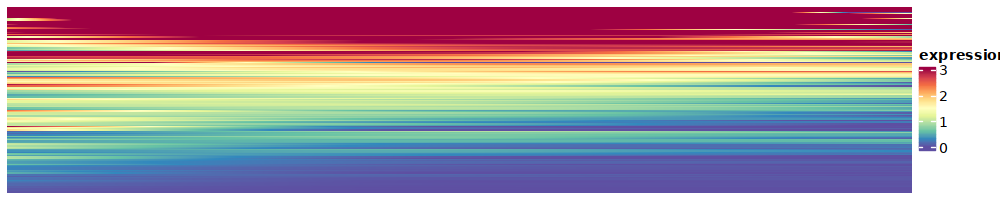

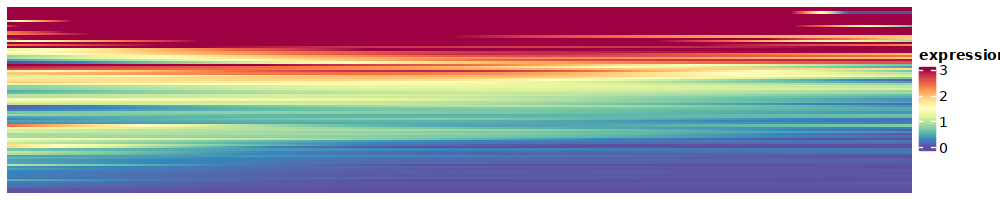

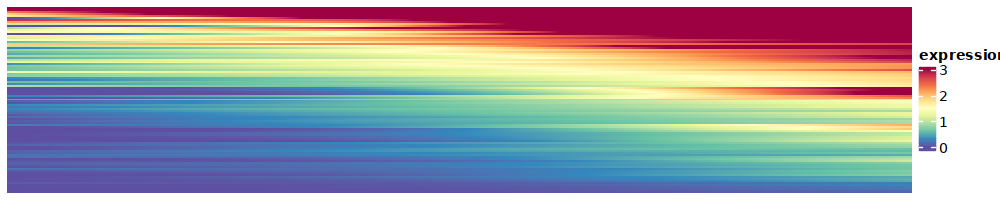

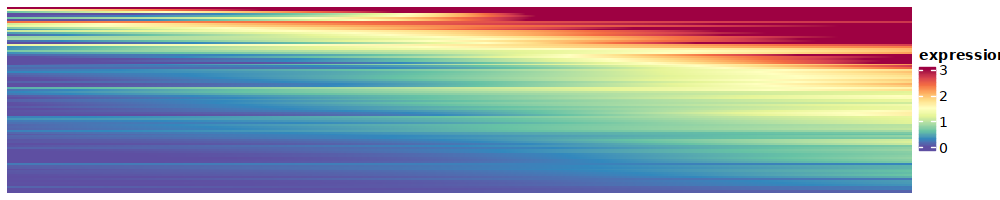

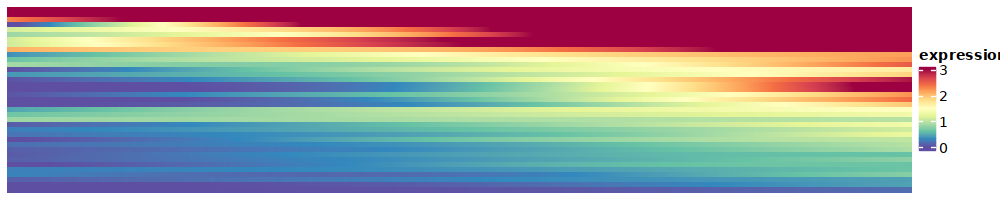

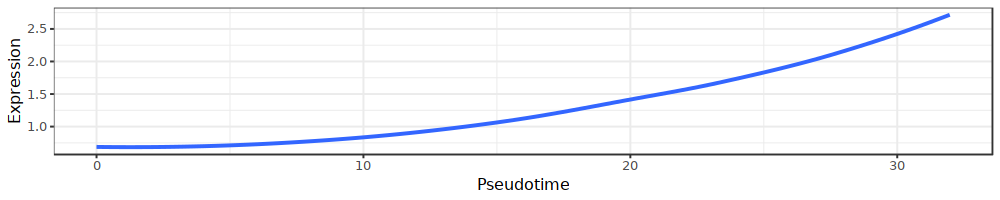

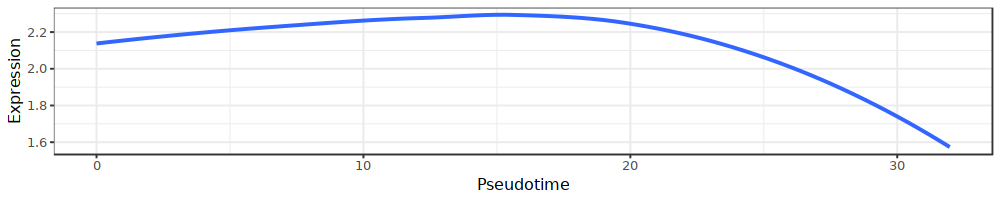

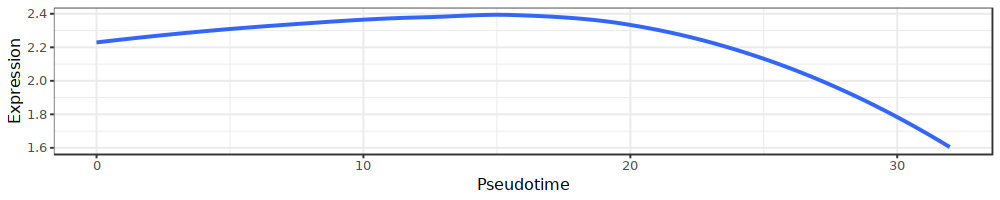

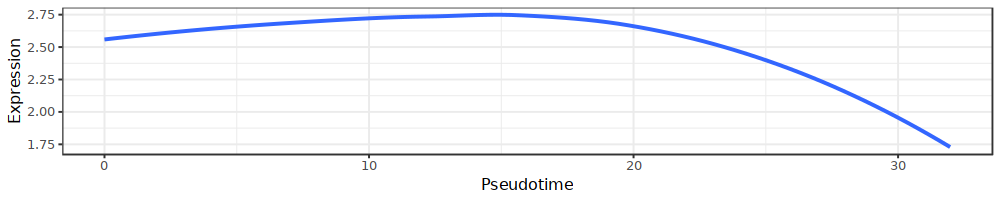

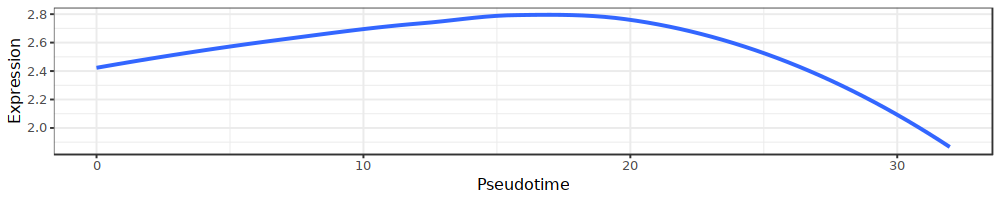

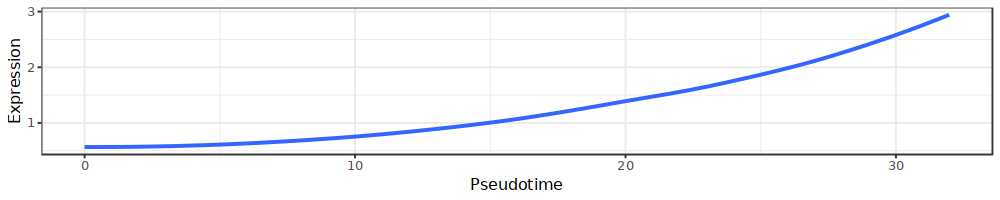

$Neurogenesis

$Neuron_differentiation

$Neuron_projection_development

$Axon_development

$Metal_ion_transport

$Cilium_organization

$Neuron_apoptotic_process


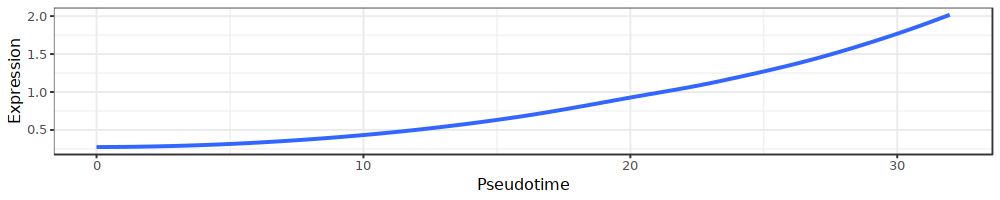

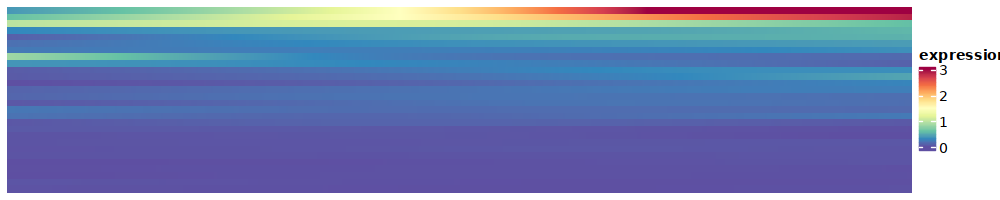

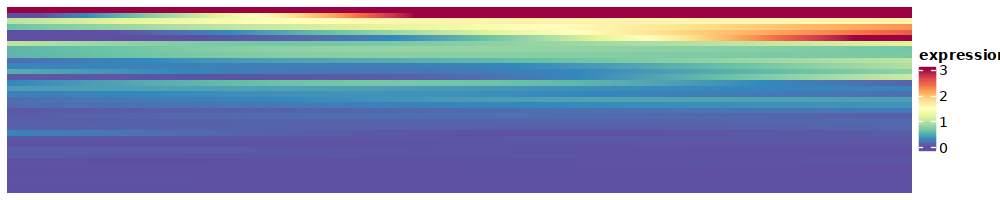

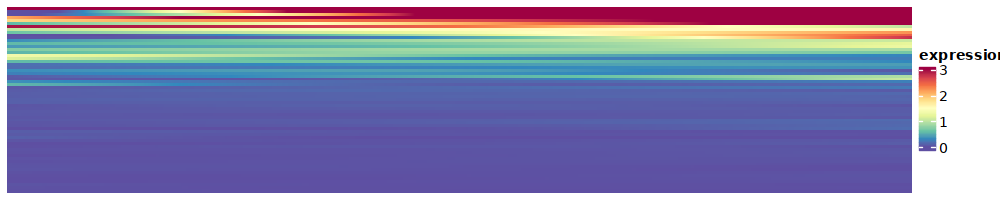

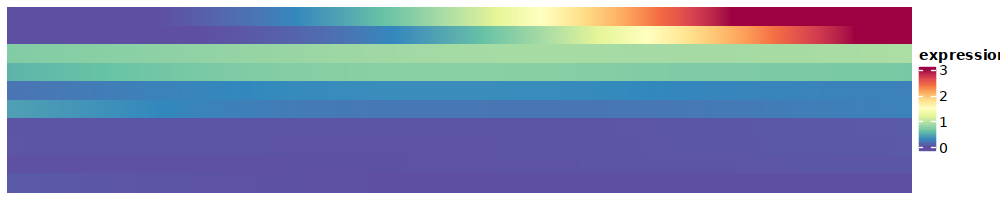

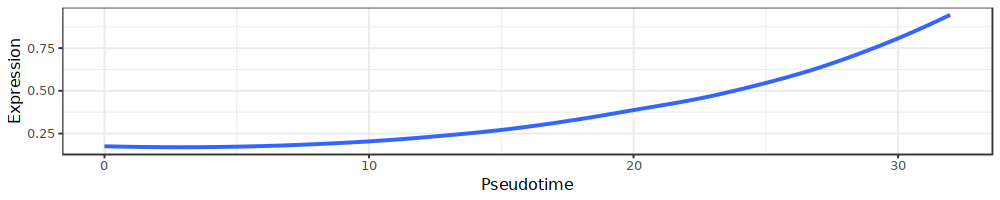

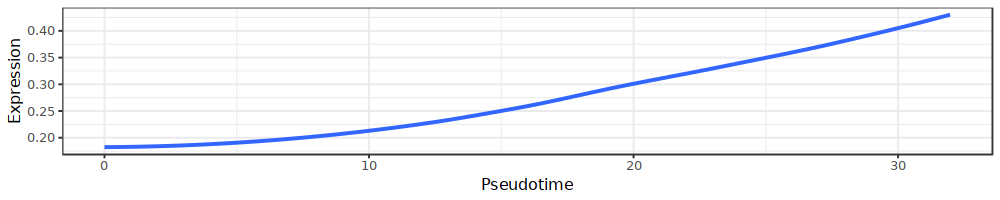

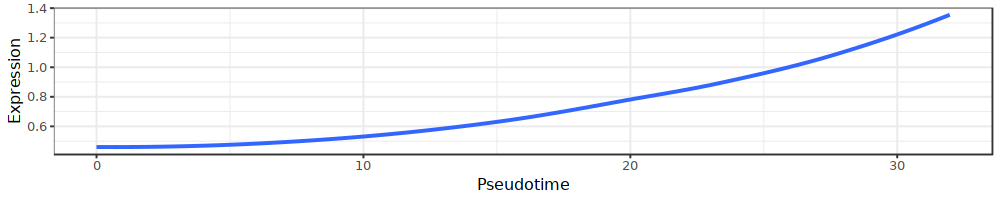

$Ensheathment_of_neurons

$Learning_or_memory

$Synapse_organization

$Myelination


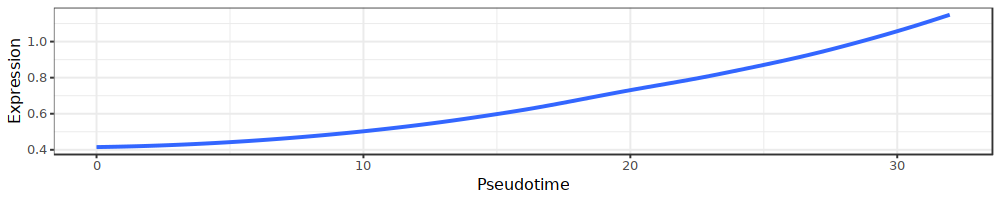

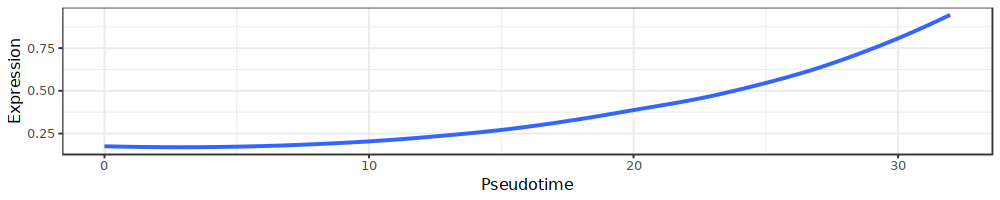

In [459]:
lapply(selected_gene_olf,plot_heatmap_trend,'')
lapply(selected_gene_brain ,plot_heatmap_trend,'')


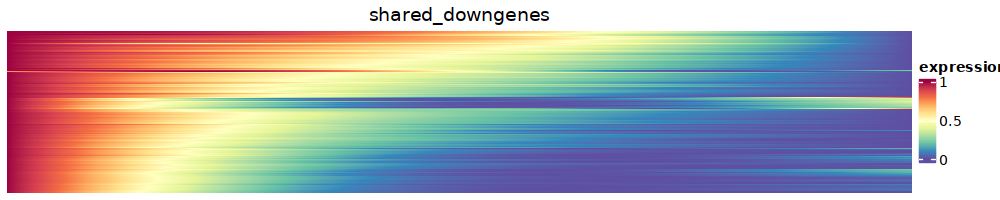

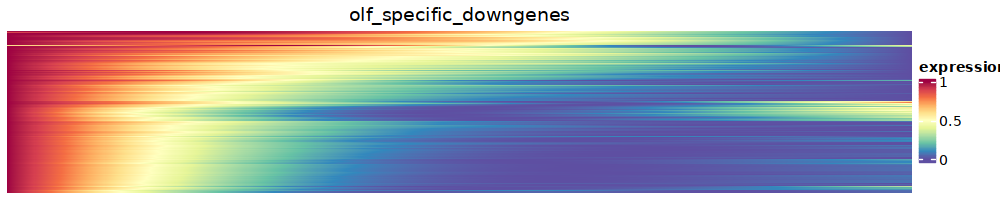

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



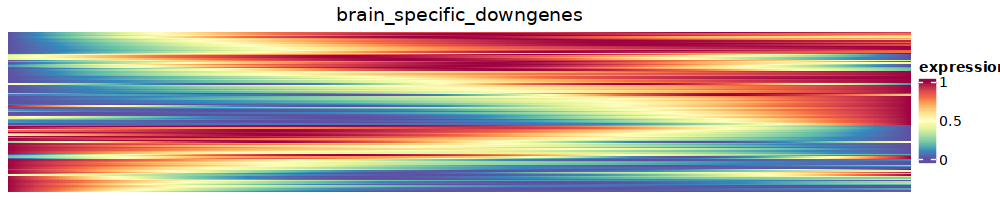

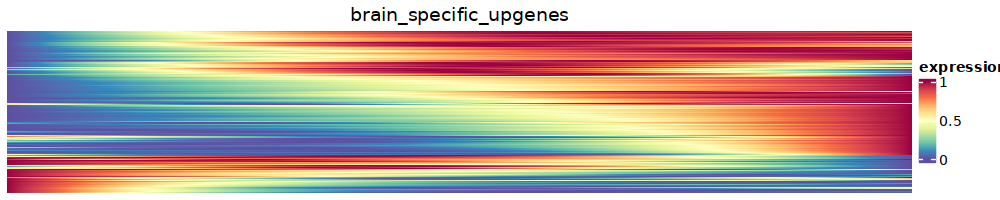

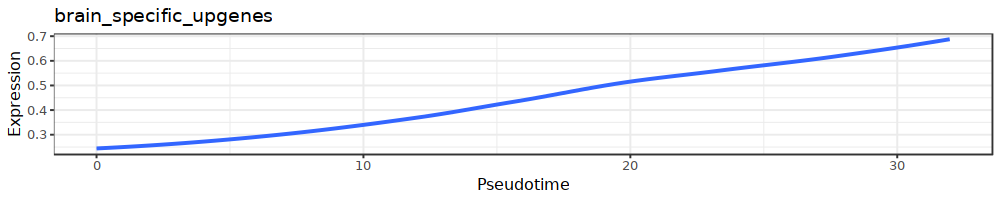

In [299]:
plot_mean_trend(DEGs=DEG_overlap_gene[['down']][['down']],'shared_downgenes')
# plot_mean_trend(DEGs=DEG_overlap_gene[['up']][['up']],'overlap_upgene')
# plot_mean_trend(DEGs=DEG_overlap_gene[['down']][['up']],'overlap_downupgene')
# plot_mean_trend(DEGs=DEG_overlap_gene[['up']][['down']],'overlap_updowngene')

plot_mean_trend(DEGs=unique_olf[['down']],'olf_specific_downgenes')


plot_mean_trend(DEGs=unique_brain[['down']],'brain_specific_downgenes')
plot_mean_trend(DEGs=unique_brain[['up']],'brain_specific_upgenes')
# plot_mean_trend(DEGs=unique_brain[['up']],'brain_specific_upgene')
# plot_mean_trend(DEGs=unique_brain[['trans_up']],'brain_specific_trans_upgene')
# plot_mean_trend(DEGs=unique_brain[['trans_down']],'brain_specific_trans_downgene')



In [ ]:

### Neuron system associated BPs
enrrs_neuro <- subset(gobps_devDEG_sig,grepl('Neur|dendrite|synap|axon |Wnt|cilium| Ion |Nervous|axonogenesis|Stem cell',term_name,ignore.case = T))
go_term_sel <- enrrs_neuro%>%group_by(comb_trend)%>%top_n(5,-p_value)
go_term_sel$term <- str_split(go_term_sel$term_name,pattern = ' \\(',simplify = T)[,1]
go_term_sel <- aggregate(term~comb_trend,go_term_sel,'paste')
go_term_sel$term

go_term_sel$comb_trend


enrrs_neuro <- subset(gobps_brain_sig,grepl('Neur|dendrite|synap|axon |Wnt|cilium| Ion |Nervous|axonogenesis|Stem cell', term_name,ignore.case = T))
go_term_sel <- enrrs_neuro%>%group_by(brain_trend)%>%top_n(5,-p_value)
go_term_sel$term <- str_split(go_term_sel$term_name,pattern = ' \\(',simplify = T)[,1]
go_term_sel <- aggregate(term~brain_trend,go_term_sel,'paste')
go_term_sel
go_term_sel$term
go_term_sel$brain_trend

enrrs_neuro <- subset(unique_olf_gobps,grepl('Neur|dendrite|synap|axon |Wnt|cilium| Ion |Nervous|axonogenesis|Stem cell', term_name,ignore.case = T))
go_term_sel <- enrrs_neuro%>%group_by(olf_trend)%>%top_n(5,-p_value)
go_term_sel$term <- str_split(go_term_sel$term_name,pattern = ' \\(',simplify = T)[,1]
go_term_sel <- aggregate(term~olf_trend,go_term_sel,'paste')
# go_term_sel
# go_term_sel$term
# go_term_sel$olf_trend


combined_gobp <- rbind(gobps_devDEG_sig%>% mutate(trend = paste0('Shared: ',comb_trend))%>% select(!c(olf_trend, brain_trend,comb_trend)) ,
unique_olf_gobps%>%mutate(trend = paste0('Olf-Specific: ',olf_trend))%>% select(!c(olf_trend)) ,
unique_brain_gobps%>%mutate(trend = paste0('Brain-Specific: ',brain_trend))%>% select(!c(brain_trend)) )%>%group_by(trend)%>%top_n(15, -p_value)
combined_gobp <- subset(combined_gobp, grepl(': down$|: down down',trend))
#combined_gobp$term <- str_split(combined_gobp$Term,pattern = '\\(',simplify = T)[,1]
combined_gobp$term_name <- factor(combined_gobp$term_name, levels = unique(combined_gobp$term_name))
combined_gobp$trend <- gsub('down down','down',combined_gobp$trend)
combined_gobp$trend <- factor(combined_gobp$trend, unique(combined_gobp$trend))

ggplot(combined_gobp, aes(x=reorder(term_name,p_value),y=-log10(p_value), 
                          fill=grepl('Neur|dendrite|synap|axon |cilium| Ion |Nervous|axonogenesis|Stem cell|projection', term_name, ignore.case = T)))+
guides(fill=guide_legend(title="Neuron system associated terms"))+
geom_bar(stat = 'identity')+facet_grid(~trend,scales = 'free_x',space = 'free')+theme_bw()+
theme(legend.position = 'top', axis.text.x = element_text(angle = 90,hjust = 1,vjust = 0.5))+
 geom_hline(yintercept=-log10(0.05), linetype="dashed", 
                color = "red", size=0.5)

#dev.print(pdf, file='./figures/enriched_term_overlap_gene_down.pdf',width=10, height=10)
# ggplot(combined_gobp, aes(x=term,y=-log10(p_value), 
#                           fill=grepl('Neur|dendrite|synap|axon |cilium| Ion |Nervous|axonogenesis|Stem cell|projection',term, Term,ignore.case = T)))+
# geom_bar(stat = 'identity')+facet_grid(trend~.,scales = 'free_y',space = 'free')+theme_bw()+
# theme(legend.position = '')+coord_flip()+guides(fill=guide_legend(title="Neuron system associated terms"))


combined_gobp <- rbind(gobps_devDEG_sig%>% mutate(trend = paste0('Shared: ',comb_trend))%>% select(!c(olf_trend, brain_trend,comb_trend)) ,
unique_olf_gobps%>%mutate(trend = paste0('Olf-Specific: ',olf_trend))%>% select(!c(olf_trend)) ,
unique_brain_gobps%>%mutate(trend = paste0('Brain-Specific: ',brain_trend))%>% select(!c(brain_trend)) )%>%group_by(trend)%>%top_n(10, -p_value)
combined_gobp <- subset(combined_gobp, grepl(': up$|: up up',trend))
#combined_gobp$term <- str_split(combined_gobp$Term,pattern = '\\(',simplify = T)[,1]
combined_gobp$term_name <- factor(combined_gobp$term_name, levels = unique(combined_gobp$term_name))
combined_gobp$trend <- gsub('up up','up',combined_gobp$trend)
combined_gobp$trend <- factor(combined_gobp$trend, unique(combined_gobp$trend))

ggplot(combined_gobp, aes(x=term_name,y=-log10(p_value), 
                          fill=grepl('Neur|dendrite|synap|axon |cilium| Ion |Nervous|axonogenesis|Stem cell|projection|myelin',term_name,ignore.case = T)))+
guides(fill=guide_legend(title="Neuron system associated terms"))+
geom_bar(stat = 'identity')+facet_grid(~trend,scales = 'free_x',space = 'free')+theme_bw()+
theme(legend.position = 'top', axis.text.x = element_text(angle = 90,hjust = 1,vjust = 0.5))+
 geom_hline(yintercept=-log10(0.05), linetype="dashed", 
                color = "red", size=0.5)

#dev.print(pdf, file='./figures/enriched_term_overlap_gene_up.pdf',width=10, height=9)
# ggplot(combined_gobp, aes(x=term,y=-log10(p_value), 
#                           fill=grepl('Neur|dendrite|synap|axon |cilium| Ion |Nervous|axonogenesis|Stem cell|projection',term, Term,ignore.case = T)))+
# geom_bar(stat = 'identity')+facet_grid(trend~.,scales = 'free_y',space = 'free')+theme_bw()+
# theme(legend.position = '')+coord_flip()+guides(fill=guide_legend(title="Neuron system associated terms"))




In [ ]:
### rrvgo

library(rrvgo)

get_bp_enrichr_reducedTerms <- function(trend,overlap,go_analysis){
  #go_analysis$GOID <- str_split(go_analysis$Term,'\\(|\\)',simplify = T)[,2]
  simMatrix <- calculateSimMatrix(go_analysis$term_id,
                                  orgdb="org.Hs.eg.db",
                                  ont="BP",
                                  method="Rel")
  
  
  scores <- setNames(-log10(as.numeric(go_analysis$p_value)), go_analysis$term_id)
  reducedTerms <- reduceSimMatrix(simMatrix,
                                  scores,
                                  orgdb="org.Hs.eg.db")
  
  treemapPlot(reducedTerms)
  print(c(trend,overlap))
    
  reducedTerms_sumscore <-  aggregate(score~parentTerm,reducedTerms, sum)
  reducedTerms_sumscore$overlap <- overlap
  reducedTerms_sumscore$trend <- trend
  reducedTerms_sumscore$term <- reducedTerms_sumscore$parentTerm
  
#   reducedTerms <- reducedTerms%>%group_by(cluster)%>%top_n(1,score)
#   reducedTerms$overlap <- overlap
#   reducedTerms$trend <- trend
#   reducedTerms$term <- reducedTerms$parentTerm
  return(reducedTerms_sumscore)
  
}


go_terms_genelevel <- c()
for(trend in c('up','down')){#,'trans_up','trans_down'
    
  for (overlp in c('overlap','olf','brain')){

    
    if(overlp=='overlap'){GO_analysis=subset(gobps_devDEG, p_value < 0.05 & olf_trend==trend & brain_trend==trend); print(c(overlp,trend  ))}
    if(overlp=='olf'){GO_analysis=subset(unique_olf_gobps, p_value < 0.05 & olf_trend==trend );  print(c(overlp,trend  ))}
    if(overlp=='brain'){GO_analysis=subset(unique_brain_gobps, p_value < 0.05 & brain_trend==trend);  print(c(overlp,trend  ))}
    go_term <- c()
    if(nrow(GO_analysis) >=5 ){
            go_term <- get_bp_enrichr_reducedTerms(trend,overlp,GO_analysis)
    }

    go_terms_genelevel <- rbind(go_terms_genelevel, go_term)
  }
}



#go_terms_genelevel
library(dplyr)
library(gridExtra)
go_term_sel <- go_terms_genelevel%>%arrange(desc(score))%>%group_by(overlap,trend)%>%top_n(5,score)
go_term_sel <- aggregate(term~trend+overlap,go_term_sel,'paste')
x <- go_term_sel%>%arrange(trend,desc(overlap ))
x
x$term